In [1]:
import os
import pandas as pd
import numpy as np
import xgboost
import utils
import scoring
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
from pprint import pprint
import pickle

from numba import njit
from matplotlib.colors import ListedColormap

from tqdm.autonotebook import tqdm
tqdm.pandas()

from itertools import repeat

DATA_PATH = "../data"

with open('models.pkl', 'rb') as fin:
    models = pickle.load(fin)

/home/ak/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [9]:
from importlib import reload

In [10]:
reload(utils)

<module 'utils' from '/home/ak/dsml_prj/19_01 IDAO/IDAO-2019-muon-id-master/utils.py'>

In [606]:
with open('models.pkl', 'wb') as fout:
    pickle.dump(models, fout)

### Изучаем поля исходных данных

In [9]:
reader = pd.read_csv(os.path.join(DATA_PATH, 'train_part_1.csv.gz'), chunksize=5)
train_chunk = reader.__next__()
reader = pd.read_csv(os.path.join(DATA_PATH, 'test_public.csv.gz'), chunksize=5)
test_chunk = reader.__next__()

In [10]:
train_chunk

,id,ncl[0],ncl[1],ncl[2],ncl[3],avg_cs[0],avg_cs[1],avg_cs[2],avg_cs[3],ndof,...,FOI_hits_T,FOI_hits_DT,FOI_hits_S,PT,P,sWeight,particle_type,label,kinWeight,weight
0,0,47,31,13,15,2.000000,1.580645,1.153846,1.133333,8,...,[ 3 11 2 7 7 5],[0 8 0 0 0 0],[0 0 1 2 2 3],1764.925899,12646.817591,1.199231,1,1,1.85646,2.226325
1,1,92,19,11,26,2.750000,2.789474,1.363636,1.230769,8,...,[ 9 10 8 4],[ 1 -1 0 4],[0 1 2 3],4511.281266,28556.630027,1.145788,1,1,1.85646,2.127109
2,2,100,21,11,12,2.930000,2.428571,1.181818,1.083333,8,...,[10 4 13 13 3 3 15 3 5],[ 0 4 10 6 0 -4 15 0 0],[0 0 1 1 1 1 1 2 3],1062.550086,17491.702634,1.139144,1,1,3.77936,4.305235
3,3,74,27,13,20,3.067568,2.518518,1.923077,1.300000,8,...,[6 6 4 8 2],[ 1 -6 0 0 0],[0 0 1 2 3],4991.074825,37192.868559,0.864863,1,1,1.85646,1.605583
4,4,18,22,8,8,1.833333,1.954546,1.125000,1.750000,8,...,[ 5 10 6 6 5 5],[ 0 5 -2 0 0 0],[0 0 0 1 2 3],1347.704888,16688.746174,1.107431,1,1,1.85646,2.055900


In [12]:
set(train_chunk.columns)-set(test_chunk.columns)

{'kinWeight', 'label', 'particle_type', 'sWeight', 'weight'}

In [39]:
list(map(len, [train_chunk.columns, utils.SIMPLE_FEATURE_COLUMNS, utils.FOI_COLUMNS, utils.TRAIN_COLUMNS, [utils.ID_COLUMN]]))

[80, 65, 9, 5, 1]

In [8]:
train_chunk.columns

Index(['id', 'ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]',
       'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'L

In [17]:
set(train_chunk.columns)-set(utils.SIMPLE_FEATURE_COLUMNS+utils.FOI_COLUMNS+utils.TRAIN_COLUMNS)

{'id'}

По результатам добавили в модуль utils признаки `FOI_hits_DZ`, `FOI_hits_DT`, `sWeight`, `kinWeight`, `particle_type` 

### Загружаем данные

In [132]:
train, test = utils.load_data_csv(DATA_PATH)

C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [25]:
train.memory_usage(deep=True).sum()

8602485264

In [26]:
test.memory_usage(deep=True).sum()

1124307233

In [32]:
train.memory_usage(deep=True)[utils.FOI_COLUMNS].sum()

5552890384

In [34]:
(train.shape, test.shape, test.shape[0]/train.shape[0])

((5445705, 79), (726095, 74), 0.13333351696428652)

In [44]:
train.isnull().sum().sum()

0

In [45]:
test.isnull().sum().sum()

0

In [50]:
test_na = (test==-9999).sum()

In [51]:
test_na[test_na>0] # пропущенные значения в тестовой выборке

MatchedHit_X[2]     11912
MatchedHit_X[3]     13050
MatchedHit_Y[2]     11912
MatchedHit_Y[3]     13050
MatchedHit_Z[2]     11912
MatchedHit_Z[3]     13050
MatchedHit_DX[2]    11912
MatchedHit_DX[3]    13050
MatchedHit_DY[2]    11912
MatchedHit_DY[3]    13050
MatchedHit_DZ[2]    11912
MatchedHit_DZ[3]    13050
dtype: int64

In [52]:
train_na = (train==-9999).sum()

In [53]:
train_na[train_na>0] # пропущенные значения в обучающей выборке

MatchedHit_X[2]     89718
MatchedHit_X[3]     97974
MatchedHit_Y[2]     89718
MatchedHit_Y[3]     97974
MatchedHit_Z[2]     89718
MatchedHit_Z[3]     97974
MatchedHit_DX[2]    89718
MatchedHit_DX[3]    97974
MatchedHit_DY[2]    89718
MatchedHit_DY[3]    97974
MatchedHit_DZ[2]    89718
MatchedHit_DZ[3]    97974
dtype: int64

In [66]:
test_mhx2_na = (test['MatchedHit_X[2]']==-9999)
test_mhx3_na = (test['MatchedHit_X[3]']==-9999)

In [71]:
sum(test_mhx2_na & test_mhx3_na) # пересечение множеств пропущенных значений

2503

In [74]:
sum(test_mhx2_na | test_mhx3_na) # объединение множеств пропущенных значений

22459

In [75]:
11912+13050-2503

22459

In [80]:
test['MatchedHit_T[2]'][test_mhx2_na].head()

id
63     255
65     255
86     255
140    255
208    255
Name: MatchedHit_T[2], dtype: int64

In [81]:
test['MatchedHit_DT[2]'][test_mhx2_na].head()

id
63    -1
65    -1
86    -1
140   -1
208   -1
Name: MatchedHit_DT[2], dtype: int64

In [133]:
train.label.value_counts()

1    5024487
0     421218
Name: label, dtype: int64

1. В обучающей выборке имеем 5.4 млн. треков., около 8 ГБ.  
2. В тестовой выборке - 726 тыс. треков (13%), около 1 ГБ.  
3. Обучающая выборка существенно несбалансирована по целевой переменной (имеется только 8% отрицательных результатов).  
4. Всего 80 признаков, из них 65 - числовых, 9 - массивы (FOI_COLUMNS), 5 - обучающих, 1 - идентификатор.  
5. 9 признаков (FOI_COLUMNS) занимают 65% памяти.  
6. Поля `MatchedHit_{X,Y,Z}[2,3]`, `MatchedHit_D{X,Y,Z}[2,3]` содержат пропущенные значения -9999 (около 2%). Соответствующие значения в столбце `MatchedHit_T` обозначены 255, `MatchedHit_DT` -1  

Далее для отработки алгоритмов будем использовать 10% обучающей выборки

In [82]:
train_10 = train.sample(frac=0.1, random_state=0)
test_10 = test.sample(frac=0.1, random_state=0)

In [83]:
(train_10.shape, test_10.shape)

((544570, 79), (72610, 74))

In [85]:
train_10.head()

,ncl[0],ncl[1],ncl[2],ncl[3],avg_cs[0],avg_cs[1],avg_cs[2],avg_cs[3],ndof,MatchedHit_TYPE[0],...,FOI_hits_T,FOI_hits_DT,FOI_hits_S,PT,P,sWeight,particle_type,label,kinWeight,weight
2774302,46,11,10,14,3.152174,1.272727,1.400000,1.714286,8,2,...,[ 3 15 6 6 10],[ 0 8 -1 0 0],[0 1 1 2 3],879.737285,4656.998885,0.943764,1,1,1.85646,1.752060
4674492,20,7,10,16,1.650000,1.000000,1.600000,1.562500,8,2,...,[ 5 5 15 7 10 8],[ 1 1 15 0 -1 0],[0 0 1 1 2 3],1808.101394,9036.762578,1.195179,1,1,1.85646,2.218803
1346953,99,27,26,19,1.737374,2.888889,1.307692,1.263158,8,2,...,[10 9 12 6 13],[ 0 -1 2 0 0],[0 1 1 2 3],1090.992151,6573.516973,1.080711,1,1,3.00000,3.242132
1136540,43,8,8,6,2.372093,1.375000,1.125000,1.166667,8,2,...,[5 6 6 2 9],[0 1 0 0 0],[0 0 1 2 3],1143.072219,10963.661222,1.210200,1,1,1.85646,2.246688
3105642,36,12,22,9,2.444444,1.750000,1.727273,1.333333,6,2,...,[7 8 4],[0 0 0],[0 1 2],1042.595726,4395.218049,1.211791,1,1,1.85646,2.249641


In [86]:
train_10.to_csv(os.path.join(DATA_PATH, 'train_10.csv'))
test_10.to_csv(os.path.join(DATA_PATH, 'test_10.csv'))

### Перезагружаем исходные данные (10% выборки)

In [97]:
train, test = utils.load_full_10_csv(DATA_PATH)

In [3]:
(train.shape, test.shape)

((544570, 79), (72610, 74))

In [19]:
train[utils.SIMPLE_FEATURE_COLUMNS].head()

,ncl[0],ncl[1],ncl[2],ncl[3],avg_cs[0],avg_cs[1],avg_cs[2],avg_cs[3],ndof,MatchedHit_TYPE[0],...,Mextra_DX2[1],Mextra_DX2[2],Mextra_DX2[3],Mextra_DY2[0],Mextra_DY2[1],Mextra_DY2[2],Mextra_DY2[3],FOI_hits_N,PT,P
0,46.0,11.0,10.0,14.0,3.152174,1.272727,1.400000,1.714286,8.0,2.0,...,8742.464844,21451.365234,45199.402344,2808.968506,8474.981445,20795.039062,43816.480469,5.0,879.737305,4656.999023
1,20.0,7.0,10.0,16.0,1.650000,1.000000,1.600000,1.562500,8.0,2.0,...,2113.700195,4832.137207,9439.530273,704.310730,2111.743896,4827.666016,9430.797852,6.0,1808.101440,9036.762695
2,99.0,27.0,26.0,19.0,1.737374,2.888889,1.307692,1.263158,8.0,2.0,...,4631.187012,11061.107422,22695.498047,1398.093994,4183.302246,9991.374023,20500.582031,5.0,1090.992188,6573.517090
3,43.0,8.0,8.0,6.0,2.372093,1.375000,1.125000,1.166667,8.0,2.0,...,1294.079346,2954.360840,5806.304688,444.476807,1297.190918,2961.463623,5820.262695,5.0,1143.072266,10963.661133
4,36.0,12.0,22.0,9.0,2.444444,1.750000,1.727273,1.333333,6.0,2.0,...,10012.363281,24960.212891,53855.460938,3234.657715,9986.380859,24895.445312,53715.714844,3.0,1042.595703,4395.218262


In [113]:
train[utils.FOI_COLUMNS].head()

,FOI_hits_X,FOI_hits_Y,FOI_hits_T,FOI_hits_Z,FOI_hits_DX,FOI_hits_DY,FOI_hits_DZ,FOI_hits_DT,FOI_hits_S
0,"[-2219.88, -2504.7, -2394.7, -2478.87, -1940.67]","[2659.536, 2866.6494, 2866.6494, 3074.9841, 24...","[3.0, 15.0, 6.0, 6.0, 10.0]","[15328.678, 16533.623, 16533.623, 17727.174, 1...","[25.5, 27.5, 27.5, 118.0, 63.0]","[126.27855, 136.27849, 136.27849, 146.27841, 7...","[33.95495, 33.99096, 33.99096, 34.026966, 33.7...","[0.0, 8.0, -1.0, 0.0, 0.0]","[0.0, 1.0, 1.0, 2.0, 3.0]"
1,"[1544.1, 1544.1, 84.51, 1584.06, 1568.6, 1677.82]","[-690.35535, -563.9562, -779.3011, -745.2013, ...","[5.0, 5.0, 15.0, 7.0, 10.0, 8.0]","[15117.513, 15117.968, 16324.493, 16324.615, 1...","[12.75, 12.75, 82.5, 13.75, 59.0, 63.0]","[63.078957, 63.078957, 33.979145, 68.078926, 7...","[33.727364, 33.727364, 33.622578, 33.74537, 33...","[1.0, 1.0, 15.0, 0.0, -1.0, 0.0]","[0.0, 0.0, 1.0, 1.0, 2.0, 3.0]"
2,"[-4148.18, -4583.8, -4528.8, -5062.87, -5406.57]","[1645.7426, 1773.5565, 1773.5565, 1902.4917, 2...","[10.0, 9.0, 12.0, 6.0, 13.0]","[15325.026, 16529.688, 16529.688, 17722.951, 1...","[25.5, 27.5, 27.5, 118.0, 126.0]","[126.27855, 136.27849, 136.27849, 146.27841, 1...","[33.95495, 33.99096, 33.99096, 34.026966, 34.0...","[0.0, -1.0, 2.0, 0.0, 0.0]","[0.0, 1.0, 1.0, 2.0, 3.0]"
3,"[-725.03, -699.53, -838.35, -1001.87, -1071.17]","[-1564.9329, -1564.9329, -1690.1172, -1813.980...","[5.0, 6.0, 6.0, 2.0, 9.0]","[15112.464, 15112.464, 16316.213, 17508.566, 1...","[12.75, 12.75, 13.75, 59.0, 63.0]","[63.078957, 63.078957, 68.078926, 73.078896, 7...","[33.727364, 33.727364, 33.74537, 33.763374, 33...","[0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 2.0, 3.0]"
4,"[-1607.88, -1844.7, -2006.87]","[3166.4326, 3413.2458, 3661.2803]","[7.0, 8.0, 4.0]","[15330.503, 16535.592, 17729.285]","[25.5, 27.5, 118.0]","[126.27855, 136.27849, 146.27841]","[33.95495, 33.99096, 34.026966]","[0.0, 0.0, 0.0]","[0.0, 1.0, 2.0]"


In [114]:
train[utils.TRAIN_COLUMNS].head()

,label,weight,sWeight,kinWeight,particle_type
0,1,1.752060,0.943764,1.85646,1
1,1,2.218803,1.195179,1.85646,1
2,1,3.242132,1.080711,3.00000,1
3,1,2.246688,1.210200,1.85646,1
4,1,2.249641,1.211791,1.85646,1


### Baseline

#### SIMPLE_FEATURE_COLUMNS, label

In [298]:
train_part, validation = train_test_split(train, test_size=0.25, shuffle=True, random_state=0)
features = utils.SIMPLE_FEATURE_COLUMNS
model = xgboost.XGBClassifier(n_jobs=-1)

In [377]:
%%time
model.fit(train_part[features].values, train_part.label.values, sample_weight=train_part.weight.values)

Wall time: 2min 13s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [382]:
validation_predictions = model.predict_proba(validation[features].values)[:, 1]

In [383]:
score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
score

0.5143225054344271

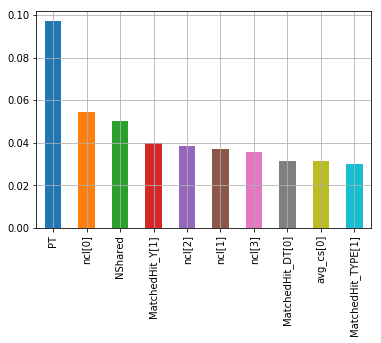

In [384]:
best_features = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
best_features[:10].plot(kind='bar', grid=True)

In [386]:
models.append({'name': 'baseline', 'score': score, 'best_features': best_features, 'fit_time': 133})

#### SIMPLE_FEATURE_COLUMNS, particle_type

Модель для исключения пионов

In [399]:
train_part, validation = train_test_split(train, test_size=0.25, shuffle=True, random_state=0)
features = utils.SIMPLE_FEATURE_COLUMNS
model = xgboost.XGBClassifier(n_jobs=-1)

In [400]:
%%time
model.fit(train_part[features].values, (train_part.particle_type!=0).values, sample_weight=train_part.weight.values)

Wall time: 2min 22s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [401]:
validation_predictions = model.predict_proba(validation[features].values)[:, 1]

In [402]:
score = scoring.rejection90((validation.particle_type!=0).values, validation_predictions, sample_weight=validation.weight.values)
score

0.3935499402228077

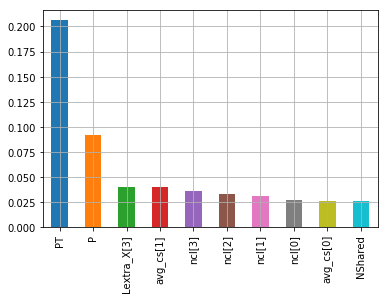

In [403]:
best_features = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
best_features[:10].plot(kind='bar', grid=True)

In [407]:
models.append({'name': 'baseline_pions', 'score': score, 'best_features': best_features, 'fit_time': 142})

Модель для исключения протонов

In [411]:
train_part, validation = train_test_split(train, test_size=0.25, shuffle=True, random_state=0)
features = utils.SIMPLE_FEATURE_COLUMNS
model = xgboost.XGBClassifier(n_jobs=-1)

In [412]:
%%time
model.fit(train_part[features].values, (train_part.particle_type!=2).values, sample_weight=train_part.weight.values)

Wall time: 2min 9s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [413]:
validation_predictions = model.predict_proba(validation[features].values)[:, 1]

In [414]:
score = scoring.rejection90((validation.particle_type!=2).values, validation_predictions, sample_weight=validation.weight.values)
score

0.6134756423538318

In [416]:
best_features = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
best_features.head()

PT           0.177233
P            0.100865
ncl[0]       0.053314
avg_cs[0]    0.046110
NShared      0.033141
dtype: float32

In [417]:
models.append({'name': 'baseline_protons', 'score': score, 'best_features': best_features, 'fit_time': 129})

Протоны идентифицируются существенно лучше пионов (61% против 39%)

### Изучение исходных данных

#### TRAIN_COLUMNS

In [120]:
utils.TRAIN_COLUMNS

['label', 'weight', 'sWeight', 'kinWeight', 'particle_type']

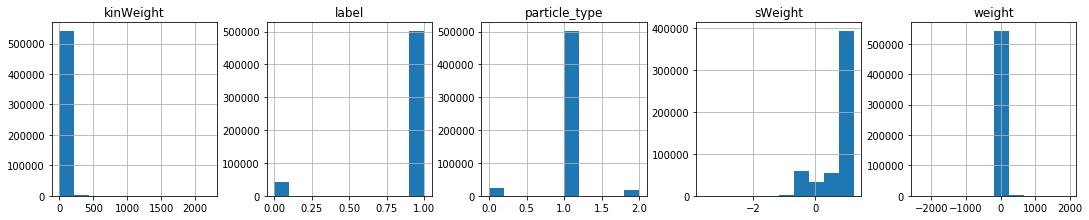

In [160]:
fig, axs = plt.subplots(1,5, figsize=(15,3))
fig.tight_layout()
train[utils.TRAIN_COLUMNS].hist(ax=axs);

In [177]:
confint(train['kinWeight'])

(1.8564598845880824, 25.117117355757934)

In [178]:
confint(train['sWeight'])

(-0.4092885919410545, 1.2340558752934343)

Поля `kinWeight` и `sWeight` имеют значительные выбросы

In [182]:
train.pivot_table(values='weight', index='label', columns='particle_type', aggfunc=len)

particle_type,0,1,2
label,,,
0,25006.0,NaN,16751.0
1,NaN,502813.0,NaN


Поле `particle_type` полностью определяет целевую переменную

#### SIMPLE_FEATURE_COLUMNS

In [429]:
features = sorted([name for name in utils.SIMPLE_FEATURE_COLUMNS if 'MatchedHit' in name])
pprint((features, len(features)), compact=True)

(['MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]',
  'MatchedHit_DT[3]', 'MatchedHit_DX[0]', 'MatchedHit_DX[1]',
  'MatchedHit_DX[2]', 'MatchedHit_DX[3]', 'MatchedHit_DY[0]',
  'MatchedHit_DY[1]', 'MatchedHit_DY[2]', 'MatchedHit_DY[3]',
  'MatchedHit_DZ[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]',
  'MatchedHit_DZ[3]', 'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]',
  'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]', 'MatchedHit_T[0]',
  'MatchedHit_T[1]', 'MatchedHit_T[2]', 'MatchedHit_T[3]', 'MatchedHit_X[0]',
  'MatchedHit_X[1]', 'MatchedHit_X[2]', 'MatchedHit_X[3]', 'MatchedHit_Y[0]',
  'MatchedHit_Y[1]', 'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
  'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]'],
 36)


In [64]:
features = sorted([name for name in utils.SIMPLE_FEATURE_COLUMNS if 'Lextra' in name])
pprint((features, len(features)), compact=True)

(['Lextra_X[0]', 'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]',
  'Lextra_Y[1]', 'Lextra_Y[2]', 'Lextra_Y[3]'],
 8)


In [65]:
features = sorted([name for name in utils.SIMPLE_FEATURE_COLUMNS if 'Mextra' in name])
pprint((features, len(features)), compact=True)

(['Mextra_DX2[0]', 'Mextra_DX2[1]', 'Mextra_DX2[2]', 'Mextra_DX2[3]',
  'Mextra_DY2[0]', 'Mextra_DY2[1]', 'Mextra_DY2[2]', 'Mextra_DY2[3]'],
 8)


Обработаем пропущенные значения

In [20]:
for s in [0,1,2,3]: #stage
    for v in ['X', 'Y', 'Z', 'DX', 'DY', 'DZ']: #var
        train[f'MatchedHit_{v}nan[{s}]'] = train[f'MatchedHit_{v}[{s}]'].apply(lambda x: np.nan if x==-9999 else x)
for s in [0,1,2,3]: #stage
    for v in ['T']: #var
        train[f'MatchedHit_{v}nan[{s}]'] = train[f'MatchedHit_{v}[{s}]'].apply(lambda x: np.nan if x==255 else x)
for s in [0,1,2,3]: #stage
    for v in ['DT']: #var
        train[f'MatchedHit_{v}nan[{s}]'] = train[f'MatchedHit_{v}[{s}]'].apply(lambda x: np.nan if x==-1 else x)

Построим распределение координаты столкновения $Z$ в зависимости от номера фильтра

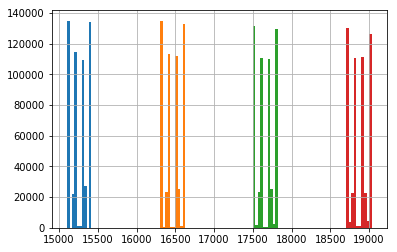

In [286]:
for s in [0,1,2,3]:
    train[f'MatchedHit_Znan[{s}]'].hist()

Построим распределение времени столкновения $T$ в зависимости от номера фильтра

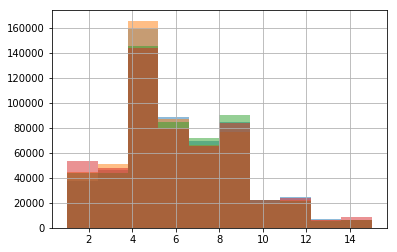

In [288]:
for s in [0,1,2,3]:
    train[f'MatchedHit_Tnan[{s}]'].hist(alpha=0.5)

In [329]:
train[[f'MatchedHit_Tnan[{s}]' for s in [0,1,2,3]]].mean() # усреднение времени по номерам фильтров

MatchedHit_Tnan[0]    6.121913
MatchedHit_Tnan[1]    5.920660
MatchedHit_Tnan[2]    6.084950
MatchedHit_Tnan[3]    6.023651
dtype: float64

In [328]:
train[[f'MatchedHit_Tnan[{s}]' for s in [0,1,2,3]]].std(axis=1).mean() # разброс значений времени одного трека

2.421696610985658

Время столкновения `MatchedHit_T` практически не зависит от номера фильтра

Построим графики треков

Усредненная координата Z мюонных фильтров

In [67]:
stations_z = [train[f'MatchedHit_Znan[{s}]'].mean() for s in [0,1,2,3]]
stations_z

[15261.277528616687,
 16467.076246876837,
 17660.206092411867,
 18868.303542113088]

In [195]:
train_sample[[f'MatchedHit_DTnan[{s}]' for s in [0,1,2,3]]]

,MatchedHit_DTnan[0],MatchedHit_DTnan[1],MatchedHit_DTnan[2],MatchedHit_DTnan[3]
0,0.0,NaN,0.0,0.0
1,1.0,0.0,NaN,0.0
2,0.0,NaN,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,NaN


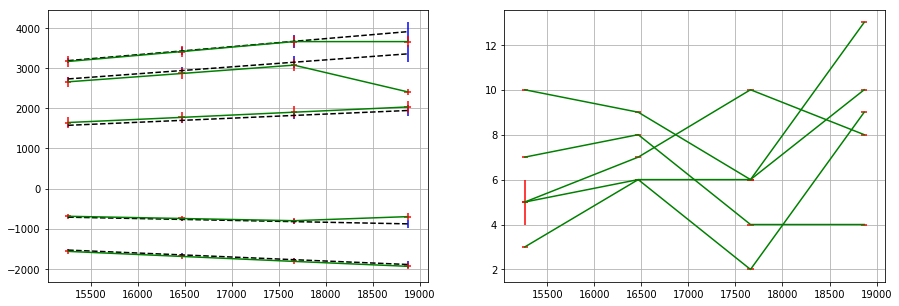

In [194]:
train_sample = train[:5]

fig, axs = plt.subplots(1,2, figsize=(15,5))

plt.sca(axs[0])
plt.grid(True)
for (_, track) in train_sample.iterrows():
    plt.errorbar(
        stations_z,
        track[[f'Lextra_Y[{s}]' for s in [0,1,2,3]]],
        yerr=track[[f'Mextra_DY2[{s}]' for s in [0,1,2,3]]]**0.5,
        color='black', ecolor='blue', linestyle='--'
    )
    plt.errorbar(
        x=stations_z,
        y=track[[f'MatchedHit_Ynan[{s}]' for s in [0,1,2,3]]].fillna(method='ffill'),
        yerr=track[[f'MatchedHit_DYnan[{s}]' for s in [0,1,2,3]]].fillna(method='ffill'),
        xerr=track[[f'MatchedHit_DZnan[{s}]' for s in [0,1,2,3]]].fillna(method='ffill'), 
        color='green', ecolor='red'
    )

plt.sca(axs[1])
plt.grid(True)
for (_, track) in train_sample.iterrows():
    plt.errorbar(
        x=stations_z,
        y=track[[f'MatchedHit_Tnan[{s}]' for s in [0,1,2,3]]].fillna(method='ffill'),
        yerr=track[[f'MatchedHit_DTnan[{s}]' for s in [0,1,2,3]]].fillna(method='ffill'),
        xerr=track[[f'MatchedHit_DZnan[{s}]' for s in [0,1,2,3]]].fillna(method='ffill'), 
        color='green', ecolor='red'
    )


Видно, что часть треков плохо согласуется с экстраполированными траекториями.  
Признаки `Lextra_X[0,1,2,3]` и `Lextra_Y[0,1,2,3]` линейно зависимы

In [191]:
k=train[[f'Lextra_Y[{s}]' for s in [0,1,2,3]]]/stations_z
k.sample(5)

,Lextra_Y[0],Lextra_Y[1],Lextra_Y[2],Lextra_Y[3]
256701,0.068076,0.068036,0.068051,0.068010
168436,0.065231,0.065183,0.065188,0.065141
2934,-0.075774,-0.075434,-0.075194,-0.074926
349544,0.028189,0.028187,0.028205,0.028198
275781,0.062378,0.062329,0.062330,0.062283


Вычислим радиусы столкновений

In [201]:
for stage in [0,1,2,3]:
    train[f'MatchedHit_R[{stage}]'] = np.sqrt(train[f'MatchedHit_Xnan[{stage}]']**2 + train[f'MatchedHit_Ynan[{stage}]']**2)

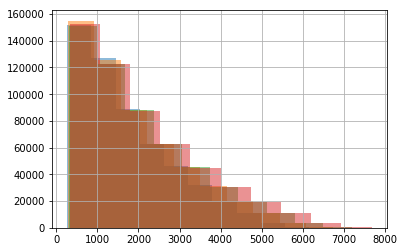

In [279]:
for s in [0,1,2,3]:
    train[f'MatchedHit_R[{s}]'].hist(alpha=0.5)

In [202]:
train[[f'MatchedHit_R[{s}]' for s in [0,1,2,3]]].mean()

MatchedHit_R[0]    1709.323312
MatchedHit_R[1]    1850.243229
MatchedHit_R[2]    1993.512828
MatchedHit_R[3]    2113.150310
dtype: float64

In [197]:
for stage in [0,1,2,3]:
    train[f'Lextra_R[{stage}]'] = np.sqrt(train[f'Lextra_X[{stage}]']**2 + train[f'Lextra_Y[{stage}]']**2)

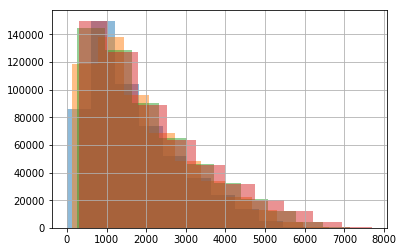

In [203]:
for s in [0,1,2,3]:
    train[f'Lextra_R[{s}]'].hist(alpha=0.5)

In [204]:
train[[f'Lextra_R[{s}]' for s in [0,1,2,3]]].mean()

Lextra_R[0]    1710.987549
Lextra_R[1]    1853.103394
Lextra_R[2]    1995.921875
Lextra_R[3]    2139.210938
dtype: float32

Среднее отлонение столкновения от оси закономерно увеличивается с увеличением номера фильтра

Посчитаем отклонение радиусов столкновений от ожидаемых

In [205]:
for stage in [0,1,2,3]:
    train[f'DR[{stage}]'] = (train[f'Lextra_R[{stage}]']-train[f'MatchedHit_R[{stage}]']).abs()

In [213]:
confint(train[f'DR[{stage}]'].fillna(method='ffill').values)

(1.5516493874188542, 376.228961796714)

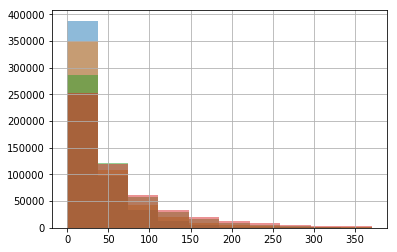

In [220]:
for s in [0,1,2,3]:
    train[f'DR[{s}]'][train[f'DR[{s}]']<370].hist(alpha=0.5)

In [222]:
train[[f'DR[{s}]' for s in [0,1,2,3]]].mean()

DR[0]    35.992125
DR[1]    46.202497
DR[2]    57.638834
DR[3]    82.346044
dtype: float64

Посчитаем ожидаемую неопределенность радиуса столкновения `MatchedHit_DR`

In [223]:
for stage in [0,1,2,3]:
    train[f'MatchedHit_DR[{stage}]'] = np.sqrt(train[f'MatchedHit_DXnan[{stage}]']**2 + train[f'MatchedHit_DYnan[{stage}]']**2)

In [225]:
confint(train[f'MatchedHit_DR[{stage}]'].fillna(method='ffill').values)

(25.063714271993646, 200.74591636735474)

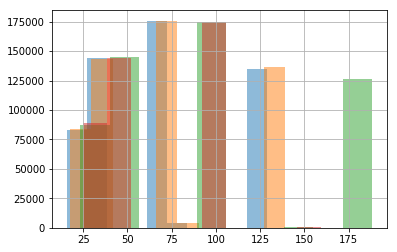

In [226]:
for s in [0,1,2,3]:
    train[f'MatchedHit_DR[{s}]'][train[f'MatchedHit_DR[{s}]']<200].hist(alpha=0.5)

In [227]:
train[[f'MatchedHit_DR[{s}]' for s in [0,1,2,3]]].mean()

MatchedHit_DR[0]     66.077985
MatchedHit_DR[1]     70.610438
MatchedHit_DR[2]     92.962698
MatchedHit_DR[3]    100.119848
dtype: float64

Посчитаем ожидаемую неопределенность радиуса столкновения `Mextra_DR`

In [229]:
for stage in [0,1,2,3]:
    train[f'Mextra_DR[{stage}]'] = np.sqrt(train[f'Mextra_DX2[{stage}]'] + train[f'Mextra_DY2[{stage}]'])

In [231]:
confint(train[f'Mextra_DR[{stage}]'].fillna(method='ffill').values)

(9.153242754936219, 273.7830268859865)

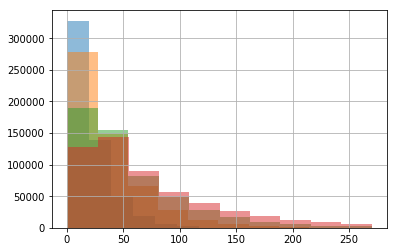

In [232]:
for s in [0,1,2,3]:
    train[f'Mextra_DR[{s}]'][train[f'Mextra_DR[{s}]']<270].hist(alpha=0.5)

In [233]:
train[[f'Mextra_DR[{s}]' for s in [0,1,2,3]]].mean()

Mextra_DR[0]    21.295521
Mextra_DR[1]    36.470898
Mextra_DR[2]    55.248318
Mextra_DR[3]    77.673393
dtype: float32

Введем флаг превышения отклонения радиуса над ожидаемой неопределенностью

In [235]:
for stage in [0,1,2,3]:
    train[f'DR_Flag[{stage}]'] = train[f'DR[{stage}]'] > train[f'MatchedHit_DR[{stage}]'] + train[f'Mextra_DR[{stage}]']

In [348]:
for stage in [0,1,2,3]:
    train[f'DR_Flag1[{stage}]'] = train[f'DR[{stage}]'] > train[f'Mextra_DR[{stage}]']

In [243]:
train[[f'DR_Flag[{s}]' for s in [0,1,2,3]]].apply(pd.Series.value_counts)

,DR_Flag[0],DR_Flag[1],DR_Flag[2],DR_Flag[3]
False,520026,516270,519276,510985
True,24544,28300,25294,33585


Добавим отклонения по осям

In [335]:
for stage in [0,1,2,3]:
    for ax in ['X', 'Y']:
        train[f'D{ax}[{stage}]'] = train[f'MatchedHit_{ax}[{stage}]'] - train[f'Lextra_{ax}[{stage}]']

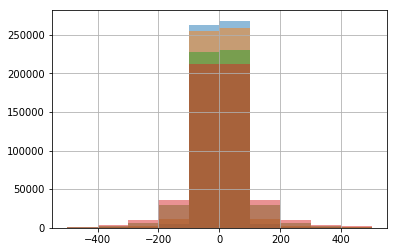

In [399]:
for s in [0,1,2,3]:
    train[f'DX[{s}]'][train[f'DX[{s}]'].abs()<500].hist(alpha=0.5)

Добавим разность неопределенностей по осям

In [346]:
for stage in [0,1,2,3]:
    for ax in ['X', 'Y']:
        train[f'D_D{ax}[{stage}]'] = train[f'MatchedHit_D{ax}[{stage}]'] - np.sqrt(train[f'Mextra_D{ax}2[{stage}]'])

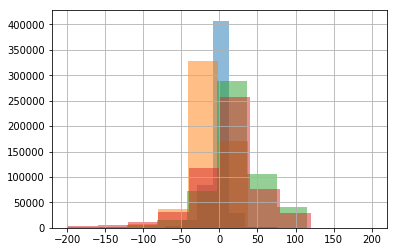

In [413]:
for s in [0,1,2,3]:
    train[f'D_DX[{s}]'][train[f'D_DX[{s}]'].abs()<200].hist(alpha=0.5)

Добавим разности между фильтами

In [464]:
for stage1 in [0,1,2,3]:
    for stage2 in range(stage1+1, 4):
        for ax in ['X', 'Y', 'Z', 'R']:
            train[f'{ax}[{stage2}-{stage1}]'] = train[f'MatchedHit_{ax}[{stage2}]'] - train[f'MatchedHit_{ax}[{stage1}]']

#### FOI_COLUMNS

In [5]:
utils.FOI_COLUMNS

['FOI_hits_X',
 'FOI_hits_Y',
 'FOI_hits_T',
 'FOI_hits_Z',
 'FOI_hits_DX',
 'FOI_hits_DY',
 'FOI_hits_DZ',
 'FOI_hits_DT',
 'FOI_hits_S']

In [75]:
# проверка на пропущенные значения
any([any(X==-9999) for X in train['FOI_hits_X']])

False

In [376]:
df1 = pd.DataFrame([[1,2,3], [4,5,6]], index=[1,2], columns=list('abc'))
df2 = pd.DataFrame([[10,20,30], [40,50,60]], index=[1,20], columns=list('cde'))

In [406]:
df1.join(df2, how='outer', rsuffix='r')

,a,b,c,cr,d,e
1,1.0,2.0,3.0,10.0,20.0,30.0
2,4.0,5.0,6.0,NaN,NaN,NaN
20,NaN,NaN,NaN,40.0,50.0,60.0


In [394]:
df1.append(df2, sort=True)

,a,b,c,d,e
1,1.0,2.0,3,NaN,NaN
2,4.0,5.0,6,NaN,NaN
1,NaN,NaN,10,20.0,30.0
20,NaN,NaN,40,50.0,60.0


In [405]:
df1.merge(df2, how='outer', left_index=True, right_index=True)

,a,b,c_x,c_y,d,e
1,1.0,2.0,3.0,10.0,20.0,30.0
2,4.0,5.0,6.0,NaN,NaN,NaN
20,NaN,NaN,NaN,40.0,50.0,60.0


In [395]:
pd.concat([df1, df2], sort=True)

,a,b,c,d,e
1,1.0,2.0,3,NaN,NaN
2,4.0,5.0,6,NaN,NaN
1,NaN,NaN,10,20.0,30.0
20,NaN,NaN,40,50.0,60.0


In [85]:
train.iloc[0][f'Mextra_DX2[0]']

2897.623

In [99]:
utils.find_closest_hit_per_station_fast(train.iloc[0])

array([0.6437442 , 0.5300128 , 1.9970778 , 5.465643  , 0.5252785 ,
       0.44330624, 0.3537038 , 4.236393  , 0.5345869 , 0.46503344,
       1.075285  , 4.799258  ], dtype=float32)

In [315]:
utils.find_closest_hit_per_station(train.iloc[0])

array([1.4702618e+03, 2.6683176e+03, 1.4108827e+05, 1.4688200e+06,
       5.1748984e+03, 5.3152500e+03, 5.2785405e+03, 8.9578600e+05,
       3.0000000e+00, 1.5000000e+01, 6.0000000e+00, 1.0000000e+01,
       1.5328678e+04, 1.6533623e+04, 1.7727174e+04, 1.8815875e+04,
       2.5500000e+01, 2.7500000e+01, 1.1800000e+02, 6.3000000e+01,
       1.2627855e+02, 1.3627849e+02, 1.4627841e+02, 7.8078857e+01],
      dtype=float32)

In [100]:
%%time
for (i, row) in train.iloc[:10000].iterrows():
    utils.find_closest_hit_per_station_fast(row)

Wall time: 5.99 s


In [320]:
%%time
for (i, row) in train.iloc[:10000].iterrows():
    utils.find_closest_hit_per_station(row)

Wall time: 11.4 s


In [408]:
%%time
foi_df = train.iloc[:1000].progress_apply(
    utils.find_closest_hit_per_station_fast, result_type="expand", axis=1)

Wall time: 550 ms


In [372]:
foi_df.columns = (
    [f'closest_x_per_station[{s}]' for s in [0,1,2,3]] +
    [f'closest_y_per_station[{s}]' for s in [0,1,2,3]] +
    [f'closest_T_per_station[{s}]' for s in [0,1,2,3]] +
    [f'closest_z_per_station[{s}]' for s in [0,1,2,3]] +
    [f'closest_dx_per_station[{s}]' for s in [0,1,2,3]] +
    [f'closest_dy_per_station[{s}]' for s in [0,1,2,3]]  
)

In [373]:
foi_df.head()

,closest_x_per_station[0],closest_x_per_station[1],closest_x_per_station[2],closest_x_per_station[3],closest_y_per_station[0],closest_y_per_station[1],closest_y_per_station[2],closest_y_per_station[3],closest_T_per_station[0],closest_T_per_station[1],...,closest_z_per_station[2],closest_z_per_station[3],closest_dx_per_station[0],closest_dx_per_station[1],closest_dx_per_station[2],closest_dx_per_station[3],closest_dy_per_station[0],closest_dy_per_station[1],closest_dy_per_station[2],closest_dy_per_station[3]
0,-2219.879883,-2504.699951,-2478.870117,-1940.670044,2659.535889,2866.649414,3074.984131,2409.260498,3.0,15.0,...,17727.173828,18815.875000,25.50,27.50,118.0,63.0,126.278549,136.278488,146.278412,78.078857
1,1544.099976,1584.060059,1568.599976,1677.819946,-690.355347,-745.201294,-800.077881,-698.870605,5.0,7.0,...,17518.017578,18727.283203,12.75,13.75,59.0,63.0,63.078957,68.078926,73.078896,78.078857
2,-4148.180176,-4528.799805,-5062.870117,-5406.569824,1645.742554,1773.556519,1902.491699,2033.061646,10.0,12.0,...,17722.951172,18931.521484,25.50,27.50,118.0,126.0,126.278549,136.278488,146.278412,156.278351
3,-699.530029,-838.349976,-1001.869995,-1071.170044,-1564.932861,-1690.117188,-1813.980469,-1936.408813,6.0,6.0,...,17508.566406,18716.226562,12.75,13.75,59.0,63.0,63.078957,68.078926,73.078896,78.078857
4,-1607.880005,-1844.699951,-2006.869995,1000.000000,3166.432617,3413.245850,3661.280273,1000.000000,7.0,8.0,...,17729.285156,1000.000000,25.50,27.50,118.0,1000.0,126.278549,136.278488,146.278412,1000.000000


In [364]:
# изучаем информацию по отдельному треку
i = 0
foi_df = pd.DataFrame(np.array(train.iloc[i][utils.FOI_COLUMNS].tolist()).T, columns=utils.FOI_COLUMNS)
foi_df['FOI_hits_R'] = np.sqrt(foi_df['FOI_hits_X']**2 + foi_df['FOI_hits_Y']**2)
foi_df['FOI_hits_DR'] = np.sqrt(foi_df['FOI_hits_DX']**2 + foi_df['FOI_hits_DY']**2)

foi_df['ID'] = foi_df.index
foi_df

,FOI_hits_X,FOI_hits_Y,FOI_hits_T,FOI_hits_Z,FOI_hits_DX,FOI_hits_DY,FOI_hits_DZ,FOI_hits_DT,FOI_hits_S,FOI_hits_R,FOI_hits_DR,ID
0,-2219.879883,2659.535889,3.0,15328.677734,25.5,126.278549,33.954948,0.0,0.0,3464.245605,128.827499,0
1,-2504.699951,2866.649414,15.0,16533.623047,27.5,136.278488,33.990959,8.0,1.0,3806.730957,139.025452,1
2,-2394.699951,2866.649414,6.0,16533.623047,27.5,136.278488,33.990959,-1.0,1.0,3735.273438,139.025452,2
3,-2478.870117,3074.984131,6.0,17727.173828,118.0,146.278412,34.026966,0.0,2.0,3949.724609,187.939819,3
4,-1940.670044,2409.260498,10.0,18815.875000,63.0,78.078857,33.781380,0.0,3.0,3093.660645,100.326012,4


In [101]:
# группировка столкновений по фильтрам
@njit
def gen_counts_cycle(array1d, counts_i):
    for v in array1d:
        counts_i[int(v)] += 1

def gen_counts(array2d):
    counts = np.zeros((len(array2d),4))
    for (array1d, counts_i) in zip(array2d, counts):
        gen_counts_cycle(array1d, counts_i)
    return counts

In [104]:
%%time
counts = gen_counts(train['FOI_hits_S'])

Wall time: 686 ms


In [179]:
counts

array([[1., 2., 1., 1.],
       [2., 2., 1., 1.],
       [1., 2., 1., 1.],
       ...,
       [1., 4., 1., 1.],
       [4., 3., 1., 1.],
       [1., 1., 1., 1.]])

In [188]:
# приращение количества столкновений
train['FOI_hits_Ninc'] = (counts[:,1:]-counts[:,:-1]).clip(0).sum(axis=1)

array([1., 0., 1., ..., 3., 0., 0.])

In [28]:
counts = gen_counts(train['FOI_hits_S']);
for stage in [0,1,2,3]:
    train[f'FOI_hits_N[{stage}]'] = counts[:,stage]

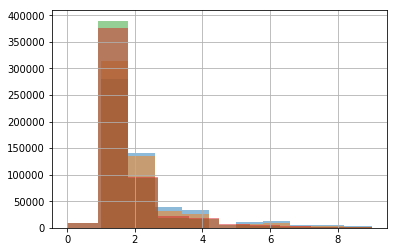

In [29]:
for s in [0,1,2,3]:
    train[f'FOI_hits_N[{s}]'][train[f'FOI_hits_N[{s}]']<10].hist(alpha=0.5)

In [38]:
tracks = train.sort_values('FOI_hits_N', ascending=False)[:10]

In [64]:
[tracks[f'MatchedHit_X[{s}]'].values[n] for s in [0,1,2,3]]

[-504.08835, -489.425, -490.67, -493.40332]

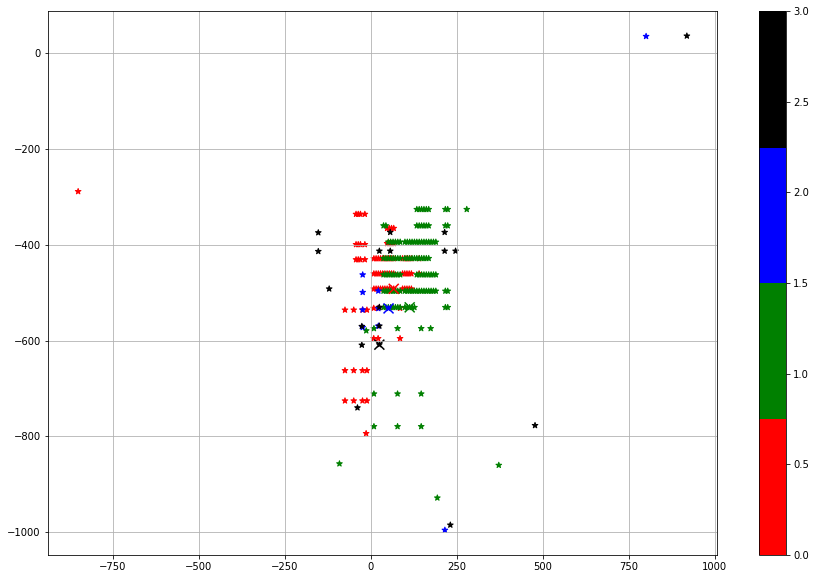

In [362]:
# визуализация данных по отдельному треку

n = 0
cmap = ListedColormap(['Red', 'Green', 'Blue', 'Black'])
plt.figure(figsize=(15,10))
plt.grid(True)
plt.scatter(tracks['FOI_hits_X'].values[n], tracks['FOI_hits_Y'].values[n], c=tracks['FOI_hits_S'].values[n], cmap=cmap, marker='*')
plt.scatter([tracks[f'MatchedHit_X[{s}]'].values[n] for s in [0,1,2,3]], 
            [tracks[f'MatchedHit_Y[{s}]'].values[n] for s in [0,1,2,3]], c=[0,1,2,3], s=100, cmap=cmap, marker='x')
plt.colorbar()

### Формирование признаков

#### Simple features

In [2]:
def build_features(sample):
    feature_sets = dict()

    # ------ Радиусы и неопределенности ------
    
    # радиусы столкновений и неопределенности координат
    for stage in [0,1,2,3]:
        sample[f'MatchedHit_R[{stage}]'] = np.sqrt(sample[f'MatchedHit_X[{stage}]']**2 + sample[f'MatchedHit_Y[{stage}]']**2)
        sample[f'Lextra_R[{stage}]'] = np.sqrt(sample[f'Lextra_X[{stage}]']**2 + sample[f'Lextra_Y[{stage}]']**2)
        sample[f'MatchedHit_DR[{stage}]'] = np.sqrt(sample[f'MatchedHit_DX[{stage}]']**2 + sample[f'MatchedHit_DY[{stage}]']**2)
        sample[f'Mextra_DR2[{stage}]'] = sample[f'Mextra_DX2[{stage}]'] + sample[f'Mextra_DY2[{stage}]']
    
    # расчетная неопределенность координат и радиуса (извлекаем корни)
    for stage in [0,1,2,3]:
        for ax in ['X', 'Y', 'R']:
            sample[f'Mextra_D{ax}[{stage}]'] = np.sqrt(sample[f'Mextra_D{ax}2[{stage}]'])
    
    # ------ Отклонения расчетных и измеренных показателей ------

    # неопределенность разности измеренных и расчетных показателей (нормировочные коэффициенты)
    for stage in [0,1,2,3]:
        for ax in ['X', 'Y', 'R']:
            sample[f'D_Delta_{ax}[{stage}]'] = np.sqrt(sample[f'MatchedHit_D{ax}[{stage}]']**2 + sample[f'Mextra_D{ax}2[{stage}]'])
    
    # отклонение координат и радиуса
    for stage in [0,1,2,3]:
        for ax in ['X', 'Y', 'R']:
            sample[f'Delta_{ax}[{stage}]'] = sample[f'MatchedHit_{ax}[{stage}]'] - sample[f'Lextra_{ax}[{stage}]']
            sample[f'Delta_{ax}_norm[{stage}]'] = sample[f'Delta_{ax}[{stage}]'].abs()/sample[f'D_Delta_{ax}[{stage}]']

    # расстояние
    for stage in [0,1,2,3]:
        sample[f'Delta_D[{stage}]'] = np.sqrt(sample[f'Delta_X[{stage}]']**2 + sample[f'Delta_Y[{stage}]']**2)
        sample[f'Delta_D_norm[{stage}]'] = sample[f'Delta_D[{stage}]']/sample[f'D_Delta_R[{stage}]']

    # продольное отклонение
    for stage in [0,1,2,3]:
        sample[f'Delta_L[{stage}]'] = np.sqrt((sample[f'Delta_D[{stage}]']**2 - sample[f'Delta_R[{stage}]']**2).clip(0))
        sample[f'Delta_L_norm[{stage}]'] = sample[f'Delta_L[{stage}]']/sample[f'D_Delta_R[{stage}]']


def get_feature_sets():
    # ------ Каталог признаков ------

    feature_sets = dict()
    
    # измеренные координаты и их неопределенности
    feature_sets['matched_hit_xy'] = set([f'MatchedHit_{ax}[{stage}]' for stage in [0,1,2,3] for ax in ['X', 'Y']])
    feature_sets['matched_hit_zt'] = set([f'MatchedHit_{ax}[{stage}]' for stage in [0,1,2,3] for ax in ['Z', 'T']])
    
    feature_sets['d_matched_hit_xy'] = set([f'MatchedHit_D{ax}[{stage}]' for stage in [0,1,2,3] for ax in ['X', 'Y']])
    feature_sets['d_matched_hit_zt'] = set([f'MatchedHit_D{ax}[{stage}]' for stage in [0,1,2,3] for ax in ['Z', 'T']])

    # расчетные координаты и их неопределенности
    feature_sets['lextra'] = set([f'Lextra_{ax}[{stage}]' for stage in [0,1,2,3] for ax in ['X', 'Y']])
    feature_sets['d_mextra'] = set([f'Mextra_D{ax}[{stage}]' for stage in [0,1,2,3] for ax in ['X', 'Y']])

    # радиусы и их неопределенности
    feature_sets['r'] = set(
        [f'MatchedHit_R[{stage}]' for stage in [0,1,2,3]] +
        [f'MatchedHit_DR[{stage}]' for stage in [0,1,2,3]] +
        [f'Lextra_R[{stage}]' for stage in [0,1,2,3]] +
        [f'Mextra_DR[{stage}]' for stage in [0,1,2,3]]
    )
    
    # отклонения и их неопределенности
    feature_sets['d_delta'] = set([f'D_Delta_{ax}[{stage}]' for stage in [0,1,2,3] for ax in ['X', 'Y', 'R']])
    
    feature_sets['delta_xyd'] = set([f'Delta_{ax}[{stage}]' for stage in [0,1,2,3] for ax in ['X', 'Y', 'D']])
    feature_sets['delta_rld'] = set([f'Delta_{ax}[{stage}]' for stage in [0,1,2,3] for ax in ['R', 'L', 'D']])

    feature_sets['delta_xyd_norm'] = set([f'Delta_{ax}_norm[{stage}]' for stage in [0,1,2,3] for ax in ['X', 'Y', 'D']])
    feature_sets['delta_rld_norm'] = set([f'Delta_{ax}_norm[{stage}]' for stage in [0,1,2,3] for ax in ['R', 'L', 'D']])
    
    feature_sets['all'] = set.union(*feature_sets.values())

    return feature_sets
    
feature_sets = get_feature_sets()

ORIGINAL_FEATURES = set([
    'ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 
    'avg_cs[0]', 'avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 
    'ndof',
    'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
    'NShared',
    'FOI_hits_N', 'PT', 'P'])

SIMPLE_FEATURES_45 = set(pd.DataFrame(models).set_index('name').loc['systematic_1_45'].best_features.index)

#### FOI features

In [ ]:
def build_foi_features(foi_sample):
    foi_features = foi_sample.progress_apply(
        utils.find_closest_hit_per_station_fast, result_type="expand", axis=1)
    
    return foi_features

In [11]:
train_foi, test_foi = utils.load_foi_csv(DATA_PATH)

In [5]:
train_foi_features = build_foi_features(train_foi)

In [12]:
test_foi_features = build_foi_features(test_foi)

In [14]:
train_foi_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.047544,0.086016,0.034877,0.721878,0.139970,0.086016,0.298594,0.721878,0.232396,0.086016,0.562311,0.721878,0.324822,0.086016,0.826028,0.721878,0.417248,0.086016,1.089745,0.721878
1,0.102610,0.064698,0.292861,0.101546,0.102610,0.064698,0.292861,0.101546,0.102610,0.064698,0.292861,0.101546,0.102610,0.064698,0.292861,0.101546,0.102610,0.064698,0.292861,0.101546
2,0.297587,0.279580,1.122164,0.939641,29.183681,0.439937,1.122164,0.939641,58.069775,1.687286,1.122164,0.939641,86.955872,1.712841,1.122164,0.939641,115.841965,4.659768,1.122164,0.939641
3,0.054989,0.112722,0.081391,0.034444,0.784015,0.112722,0.081391,0.034444,1.513041,0.112722,0.081391,0.034444,2.242067,0.112722,0.081391,0.034444,2.971093,0.112722,0.081391,0.034444
4,0.727626,0.647882,0.412200,0.306336,1.073516,0.647882,0.412200,0.306336,1.419407,0.647882,0.412200,0.306336,1.610930,0.647882,0.412200,0.306336,1.802453,0.647882,0.412200,0.306336


In [7]:
train_foi_features.to_csv(os.path.join(DATA_PATH, 'train_foi_features.csv'))

In [15]:
test_foi_features.to_csv(os.path.join(DATA_PATH, 'test_foi_features.csv'))

In [16]:
del(train_foi, test_foi)

### Track1

In [ ]:
xgboost.XGBClassifier.fit()

In [91]:
def run_model(train_part, validation, model_name, 
              features, xgb_params, 
              useTrainCV=True):
    print('RUNNING: ' + model_name)

    model = xgboost.XGBClassifier(n_jobs=3, random_state=0, **xgb_params)    
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgboost.DMatrix(train_part[features].values, label=train_part['label'].values, weight=train_part.weight.values)
        cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=3,
            metrics='auc', early_stopping_rounds=50)
        model.set_params(n_estimators=cvresult.shape[0])
    
    print('n_estimators', cvresult.shape[0])
    
    model.fit(train_part[features].values, train_part.label.values, sample_weight=train_part.weight.values)
    validation_predictions = model.predict_proba(validation[features].values)[:, 1]
    score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
    best_features = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
#     models.append({'name': model_name, 'score': score, 'best_features': best_features, 'xgb_params': xgb_params})
#     with open('models.pkl', 'wb') as fout:
#         pickle.dump(models, fout)
    print(f'score={score}')
    
#     predictions = model.predict_proba(test[features].values)[:, 1]
#     pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv(
#         f"submission_{model_name}.csv", index_label=utils.ID_COLUMN)
    
#     model.save_model(f"submission_{model_name}.xgb")
    
    return (best_features, score)

    
def run_2models(train, model_name, test_size, 
#                features_ref, xgb_params_ref,
                features2, xgb_params2, 
                features0, xgb_params0):

    train_part, validation = train_test_split(train, test_size=test_size, shuffle=True, random_state=0)

    print('RUNNING: ' + model_name)
    
#     #reference model
#     model_ref = xgboost.XGBClassifier(n_jobs=3, random_state=0, **xgb_params_ref)
#     model_ref.fit(train_part[features_ref].values, (train_part.particle_type==1).values, sample_weight=train_part.weight.values)
#     validation_predictions_ref = model_ref.predict_proba(validation[features_ref].values)[:, 1]
#     train_predictions_ref = model_ref.predict_proba(train_part[features_ref].values)[:, 1]
#     score_ref = scoring.rejection90((validation.particle_type==1).values, validation_predictions_ref, sample_weight=validation.weight.values)
#     best_features_ref = pd.Series(model_ref.feature_importances_, index=features_ref).sort_values(ascending=False)
#     models.append({'name': model_name + '_REF', 'score': score_ref, 'best_features': best_features_ref, 
#                    'validation_predictions': validation_predictions_ref, 'train_predictions': train_predictions_ref})
#     print(f'score_ref={score_ref}')
    
    # protons
    model = xgboost.XGBClassifier(n_jobs=3, random_state=0, **xgb_params2)
    model.fit(train_part[features2].values, (train_part.particle_type!=2).values, sample_weight=train_part.weight.values)
    validation_predictions_2 = model.predict_proba(validation[features2].values)[:, 1]
    train_predictions_2 = model.predict_proba(train_part[features2].values)[:, 1]
    score2 = scoring.rejection90((validation.particle_type!=2).values, validation_predictions_2, sample_weight=validation.weight.values)
    best_features_2 = pd.Series(model.feature_importances_, index=features2).sort_values(ascending=False)
    models.append({'name': model_name + '_PROTON', 'score': score2, 'best_features': best_features_2, 
                   'validation_predictions': validation_predictions_2, 'train_predictions': train_predictions_2})
    print(f'score_proton={score2}')
    predictions2 = model.predict_proba(test[features2].values)[:, 1]
    
    # non protons
    train_part0 = train_part[train_part.particle_type!=2]
    validation0 = validation[validation.particle_type!=2]
    
    # pions
    model = xgboost.XGBClassifier(n_jobs=3, random_state=0, **xgb_params0)
    model.fit(train_part0[features0].values, (train_part0.particle_type!=0), sample_weight=train_part0.weight.values)
    validation_predictions_0 = model.predict_proba(validation0[features0].values)[:, 1]
    validation_predictions_0_full = model.predict_proba(validation[features0].values)[:, 1]
    train_predictions_0 = model.predict_proba(validation[features0].values)[:, 1]
    score0 = scoring.rejection90((validation0.particle_type!=0).values, validation_predictions_0, sample_weight=validation0.weight.values)
    score0_full = scoring.rejection90((validation.particle_type!=0).values, validation_predictions_0_full, sample_weight=validation.weight.values)
    best_features_0 = pd.Series(model.feature_importances_, index=features0).sort_values(ascending=False)
    models.append({'name': model_name + '_PION', 'score': score0, 'score_full': score0_full, 'best_features': best_features_0, 
                   'validation_predictions': validation_predictions_0_full, 'train_predictions': train_predictions_0})
    print(f'score_pion={score0}')
    print(f'score_pion_full={score0_full}')
    predictions0 = model.predict_proba(test[features0].values)[:, 1]
    
    validation_predictions = validation_predictions_2 * validation_predictions_0_full
    score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
    print(f'score={score}')
    
    with open('models.pkl', 'wb') as fout:
        pickle.dump(models, fout)
    
    predictions = predictions2 * predictions0

    pd.DataFrame(data={"prediction": predictions2}, index=test.index).to_csv(
        f"submission_{model_name}_PROTON.csv", index_label=utils.ID_COLUMN)

    pd.DataFrame(data={"prediction": predictions0}, index=test.index).to_csv(
        f"submission_{model_name}_PION.csv", index_label=utils.ID_COLUMN)
    
    pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv(
        f"submission_{model_name}_2MODELS.csv", index_label=utils.ID_COLUMN)

#    return (best_features_ref, best_features_2, best_features_0)
    
FOI_FEATURES = set([str(i) for i in range(20)])

#### Отбор признаков

In [16]:
types = dict(zip(features, repeat(np.float32)))
types['id'] = np.int64
types['label'] = np.int64
train = pd.read_csv(os.path.join(DATA_PATH, 'full_train_10.csv'), 
                    dtype=types, index_col='id')

# train = pd.read_csv(os.path.join(DATA_PATH, 'full_train.csv'), 
#                     usecols=list(features)+['label', 'weight', 'id'], dtype=types, index_col='id')
# test = pd.read_csv(os.path.join(DATA_PATH, 'full_test.csv'), 
#                    usecols=list(features)+['id'], dtype=types, index_col='id')

In [25]:
feature_sets.keys()

dict_keys(['matched_hit_xy', 'matched_hit_zt', 'd_matched_hit_xy', 'd_matched_hit_zt', 'lextra', 'd_mextra', 'r', 'd_delta', 'delta_xyd', 'delta_rld', 'delta_xyd_norm', 'delta_rld_norm', 'all'])

##### От полного набора

In [93]:
features153 = feature_sets['all'] | ORIGINAL_FEATURES | FOI_FEATURES

In [110]:
features100 = (list(best_features_153[0][:100].index), list(best_features_153[1][:100].index), list(best_features_153[2][:100].index))

In [122]:
features80 = (list(best_features_100[0][:80].index), list(best_features_100[1][:80].index), list(best_features_100[2][:80].index))

In [133]:
features60 = (list(best_features_80[0][:60].index), list(best_features_80[1][:60].index), list(best_features_80[2][:60].index))

In [141]:
features50 = (list(best_features_60[0][:50].index), list(best_features_60[1][:50].index), list(best_features_60[2][:50].index))

In [147]:
features45 = (list(best_features_50[0][:45].index), list(best_features_50[1][:45].index), list(best_features_50[2][:45].index))

##### От частичного набора

In [19]:
# features = (feature_sets['delta_xyd_norm'] | feature_sets['lextra'] | 
#             feature_sets['matched_hit_zt'] | feature_sets['d_matched_hit_zt'] | 
#             ORIGINAL_FEATURES | FOI_FEATURES)

features = SIMPLE_FEATURES_45 | feature_sets['delta_xyd_norm'] | feature_sets['delta_rld_norm'] | feature_sets['matched_hit_zt'] | feature_sets['d_matched_hit_zt']
len(features)

67

In [20]:
pprint(list(features), compact=True)

['ncl[0]', 'MatchedHit_X[3]', 'Delta_L_norm[1]', 'Delta_D_norm[1]',
 'D_Delta_R[3]', 'ncl[1]', 'Delta_X[3]', 'MatchedHit_DT[3]', 'PT',
 'MatchedHit_TYPE[1]', 'avg_cs[0]', 'D_Delta_X[1]', 'MatchedHit_Y[1]',
 'D_Delta_R[1]', 'Delta_D_norm[0]', 'Delta_L_norm[2]', 'Delta_Y_norm[0]',
 'MatchedHit_Y[0]', 'MatchedHit_R[3]', 'Delta_R[3]', 'D_Delta_X[3]',
 'MatchedHit_TYPE[0]', 'MatchedHit_DT[0]', 'MatchedHit_DZ[1]', 'ncl[3]',
 'MatchedHit_Z[2]', 'Delta_D_norm[2]', 'Delta_L_norm[3]', 'FOI_hits_N',
 'MatchedHit_DT[1]', 'Delta_R_norm[2]', 'MatchedHit_T[1]', 'Delta_D_norm[3]',
 'ncl[2]', 'Mextra_DX[3]', 'Delta_Y[2]', 'MatchedHit_Z[0]', 'MatchedHit_Z[1]',
 'MatchedHit_DZ[2]', 'Delta_Y_norm[1]', 'Delta_X_norm[2]', 'MatchedHit_T[2]',
 'Delta_R_norm[0]', 'MatchedHit_DZ[3]', 'MatchedHit_T[3]', 'avg_cs[1]', 'P',
 'Delta_Y_norm[2]', 'Delta_R_norm[3]', 'avg_cs[2]', 'Delta_R_norm[1]',
 'MatchedHit_T[0]', 'Lextra_Y[0]', 'avg_cs[3]', 'Delta_X_norm[0]',
 'MatchedHit_Z[3]', 'MatchedHit_DZ[0]', 'MatchedHit_Y[3]

##### Прогон модели

In [50]:
len(best_features)

153

In [103]:
SIMPLE_FEATURES_52 = res[14][0]

In [69]:
SIMPLE_FEATURES_52.to_csv('SIMPLE_FEATURES_52.scv')

In [62]:
sorted([(i, len(item[0]), item[1]) for (i, item) in enumerate(res)], key=lambda x: x[2])

[(59, 7, 0.6655645446482967),
 (55, 11, 0.6759159008546106),
 (58, 8, 0.6792943826838221),
 (49, 17, 0.6886959934487957),
 (42, 24, 0.6894801148421553),
 (46, 20, 0.6899099607190264),
 (57, 9, 0.6903663803441145),
 (51, 15, 0.69205970392668),
 (40, 26, 0.6927283087961976),
 (52, 14, 0.6928270635465676),
 (56, 10, 0.6930944382439431),
 (54, 12, 0.6942315858009337),
 (116, 49, 0.6951060094224614),
 (43, 23, 0.6951321194192037),
 (44, 22, 0.6952148627400963),
 (45, 21, 0.6952473782809435),
 (93, 84, 0.698150680031869),
 (94, 82, 0.698150680031869),
 (117, 48, 0.6989972639685532),
 (53, 13, 0.6994249403001703),
 (101, 68, 0.7002573521041294),
 (41, 25, 0.7008764138833132),
 (125, 40, 0.7013774984423794),
 (39, 27, 0.7024708643569302),
 (134, 31, 0.7026330894900665),
 (115, 50, 0.7026549037908835),
 (37, 29, 0.7033583086432309),
 (136, 29, 0.703430583955413),
 (128, 37, 0.7034393630986709),
 (114, 51, 0.7034435230724435),
 (48, 18, 0.7038419807432407),
 (18, 48, 0.7039562766361762),
 (131, 

In [49]:
features = feature_sets['all'] | ORIGINAL_FEATURES | FOI_FEATURES
best_features, score = run_model(train, f'data10_feature_selection1_{len(features)}', 0.25,
                                 list(features), dict())

RUNNING: data10_feature_selection1_153
score=0.7091159731236308


In [59]:
best_features = res[106][0]

In [60]:
%%time
#res = []
#best_features = best_features_67

for i in range(30):
    best_features = best_features[:-1]
    best_features, score = run_model(train, f'data10_feature_selection2_{len(best_features)}', 0.25,
                                     list(best_features.index), dict())
    res.append([best_features, score])

RUNNING: data10_feature_selection2_57
score=0.7139643001020857
RUNNING: data10_feature_selection2_56
score=0.7061576854007915
RUNNING: data10_feature_selection2_55
score=0.7061576854007915
RUNNING: data10_feature_selection2_54
score=0.7099997970824078
RUNNING: data10_feature_selection2_53
score=0.7136470512122639
RUNNING: data10_feature_selection2_52
score=0.709785676837064
RUNNING: data10_feature_selection2_51
score=0.7034435230724435
RUNNING: data10_feature_selection2_50
score=0.7026549037908835
RUNNING: data10_feature_selection2_49
score=0.6951060094224614
RUNNING: data10_feature_selection2_48
score=0.6989972639685532
RUNNING: data10_feature_selection2_47
score=0.7082870590930682
RUNNING: data10_feature_selection2_46
score=0.7082870590930682
RUNNING: data10_feature_selection2_45
score=0.7077497597920918
RUNNING: data10_feature_selection2_44
score=0.7076620650009715
RUNNING: data10_feature_selection2_43
score=0.7080187514284342
RUNNING: data10_feature_selection2_42
score=0.7132857979

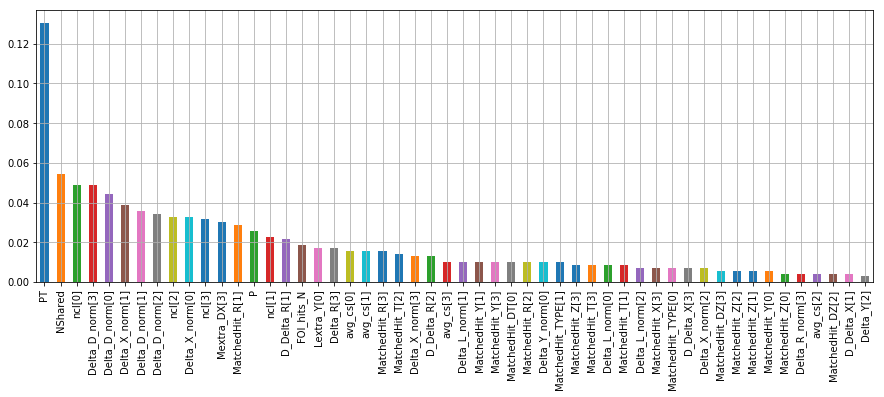

In [68]:
#best_features = pd.DataFrame(models).set_index('name').loc['f45_s75_e100_PION'].best_features
best_features = SIMPLE_FEATURES_52
best_features.plot(kind='bar', grid=True, figsize=(15,5))

In [70]:
len(best_features[best_features>0.05*best_features.iloc[2]])

52

##### Тестирование порога

In [161]:
train_part, validation = train_test_split(train[['particle_type', 'label', 'weight']], test_size=0.25, shuffle=True, random_state=0)

In [206]:
proton_val_predictions = pd.DataFrame(models).set_index('name').loc['data10_feature_selection_45_PROTON'].validation_predictions
pion_val_predictions = pd.DataFrame(models).set_index('name').loc['data10_feature_selection_45_PION'].validation_predictions
ref_val_predictions = pd.DataFrame(models).set_index('name').loc['data10_feature_selection_45_REF'].validation_predictions

In [186]:
def get_combined_score(predictions2, predictions0, labels, weights, threshold):
    predictions0_ = predictions0.copy()
    predictions0_[predictions2<threshold] = 1
    score = scoring.rejection90(labels, predictions2*predictions0_, sample_weight=weights)
    return score

In [207]:
scores = [get_combined_score(proton_val_predictions, pion_val_predictions, 
                    validation.label.values, validation.weight.values, threshold) for threshold in np.linspace(0,1,101)]

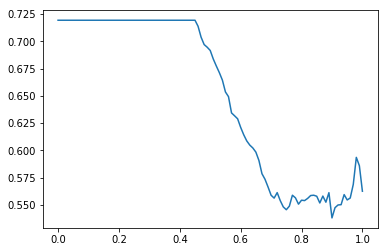

In [208]:
plt.plot(np.linspace(0,1,101), scores)

In [209]:
scoring.rejection90((validation.particle_type==1).values, proton_val_predictions*pion_val_predictions, sample_weight=validation.weight.values)

0.7192684213087752

##### Выбор лучших наборов признаков

In [229]:
pion_model_names = [model['name'] for model in models[-19:len(models):3]]
proton_model_names = [model['name'] for model in models[-20:len(models):3]]

In [240]:
res = []
for proton_model_name in proton_model_names:
    for pion_model_name in pion_model_names:
        proton_val_predictions = pd.DataFrame(models).set_index('name').loc[proton_model_name].validation_predictions
        pion_val_predictions = pd.DataFrame(models).set_index('name').loc[pion_model_name].validation_predictions
        score = scoring.rejection90(validation.label.values, proton_val_predictions*pion_val_predictions, sample_weight=validation.weight.values)
        res.append([proton_model_name, pion_model_name, score])

In [248]:
pd.DataFrame(res).sort_values(2, ascending=False).head(10)

,0,1,2
21,data10_feature_selection_60_PROTON,data10_feature_selection_153_PION,0.729134
42,data10_feature_selection_SF45_PROTON,data10_feature_selection_153_PION,0.725809
12,data10_feature_selection_100_PROTON,data10_feature_selection_45_PION,0.723284
7,data10_feature_selection_100_PROTON,data10_feature_selection_153_PION,0.722744
25,data10_feature_selection_60_PROTON,data10_feature_selection_50_PION,0.722386
26,data10_feature_selection_60_PROTON,data10_feature_selection_45_PION,0.722268
24,data10_feature_selection_60_PROTON,data10_feature_selection_60_PION,0.721401
43,data10_feature_selection_SF45_PROTON,data10_feature_selection_100_PION,0.720996
11,data10_feature_selection_100_PROTON,data10_feature_selection_50_PION,0.720859
10,data10_feature_selection_100_PROTON,data10_feature_selection_60_PION,0.720282


Попробуем выбрать лучшие модели независимо

In [231]:
pd.DataFrame([(model['name'], model['score']) for model in models[-20:len(models):3]]).sort_values(1)

,0,1
6,data10_feature_selection_SF45_PROTON,0.760183
4,data10_feature_selection_50_PROTON,0.792044
1,data10_feature_selection_100_PROTON,0.794396
5,data10_feature_selection_45_PROTON,0.795741
3,data10_feature_selection_60_PROTON,0.796522
2,data10_feature_selection_80_PROTON,0.799090
0,data10_feature_selection_153_PROTON,0.806410


In [226]:
proton_val_predictions = pd.DataFrame(models).set_index('name').loc['data10_feature_selection_80_PROTON'].validation_predictions
pion_val_predictions = pd.DataFrame(models).set_index('name').loc['data10_feature_selection_50_PION'].validation_predictions

In [227]:
get_combined_score(proton_val_predictions, pion_val_predictions, validation.label.values, validation.weight.values, 0)

0.7166872568166947

In [228]:
scoring.rejection90(validation.label.values, proton_val_predictions*pion_val_predictions, sample_weight=validation.weight.values)

0.7166872568166947

Результат получается хуже, чем просто SIMPLE_FEATURES_45

#### Настройка модели

In [75]:
train_part, validation = train_test_split(train, test_size=0.25, shuffle=True, random_state=0)

In [112]:
res[14][1]

0.7210344235808268

In [ ]:
xgboost.XGBClassifier()

In [116]:
xgb_params = {
#    'max_depth': 7,
#    'min_child_weight': 1,
#    'gamma': 0,
#    'colsample_bytree': 0.9,
#    'subsample': 0.6,
#    'reg_alpha':100,
    'learning_rate':0.3,
    'n_estimators': 5000
}

run_model(train_part, validation, 'test_model', 
          list(SIMPLE_FEATURES_52.index), xgb_params);

RUNNING: test_model
n_estimators 40
score=0.6923811297484093


In [108]:
xgb_params = {
#    'max_depth': 7,
#    'min_child_weight': 1,
#    'gamma': 0,
#    'colsample_bytree': 0.9,
#    'subsample': 0.6,
#    'reg_alpha':100,
    'n_estimators': 5000
}

run_model(train_part, validation, 'test_model', 
          list(SIMPLE_FEATURES_52.index), xgb_params);

RUNNING: test_model
n_estimators 431
score=0.7385858988694158


In [119]:
features = list(SIMPLE_FEATURES_52.index)
xgb_params = {
    'n_estimators': 40,
    'learning_rate': 0.3
}
param_test1 = {
 'max_depth': range(3,10,2),
 'min_child_weight': range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgboost.XGBClassifier(n_jobs=1, random_state=0, **xgb_params), 
                        param_grid = param_test1, scoring=scoring.rejection90_sklearn, n_jobs=3, iid=False, cv=3, verbose=10)

gsearch1.fit(train_part[features].values, train_part['label'].values, sample_weight=train_part.weight.values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=0.6485110470701249, total=  58.7s
[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=1, score=0.6626320845341018, total= 1.1min
[CV] max_depth=3, min_child_weight=3 .................................


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.2min


[CV]  max_depth=3, min_child_weight=1, score=0.650240153698367, total= 1.2min
[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=0.6626320845341018, total= 1.0min
[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=3, score=0.6485110470701249, total= 1.1min
[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=3, score=0.650240153698367, total= 1.2min
[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=5, score=0.6626320845341018, total= 1.2min
[CV] max_depth=5, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=5, score=0.6485110470701249, total=  58.5s
[CV] max_depth=5, min_child_weight=1 .................................


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  3.2min


[CV]  max_depth=3, min_child_weight=5, score=0.6501440922190201, total= 1.2min
[CV] max_depth=5, min_child_weight=1 .................................
[CV]  max_depth=5, min_child_weight=1, score=0.6666666666666666, total= 1.7min
[CV] max_depth=5, min_child_weight=3 .................................
[CV]  max_depth=5, min_child_weight=1, score=0.6585014409221902, total= 1.9min
[CV] max_depth=5, min_child_weight=3 .................................
[CV]  max_depth=5, min_child_weight=1, score=0.6538904899135447, total= 2.0min
[CV] max_depth=5, min_child_weight=3 .................................


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  5.5min


[CV]  max_depth=5, min_child_weight=3, score=0.6643611911623439, total= 2.0min
[CV] max_depth=5, min_child_weight=5 .................................
[CV]  max_depth=5, min_child_weight=3, score=0.6569644572526417, total= 1.9min
[CV] max_depth=5, min_child_weight=5 .................................
[CV]  max_depth=5, min_child_weight=3, score=0.6565802113352546, total= 1.7min
[CV] max_depth=5, min_child_weight=5 .................................
[CV]  max_depth=5, min_child_weight=5, score=0.6658981748318924, total= 1.9min
[CV] max_depth=7, min_child_weight=1 .................................
[CV]  max_depth=5, min_child_weight=5, score=0.6535062439961575, total= 1.9min
[CV] max_depth=7, min_child_weight=1 .................................
[CV]  max_depth=5, min_child_weight=5, score=0.6562920268972142, total= 1.8min
[CV] max_depth=7, min_child_weight=1 .................................
[CV]  max_depth=7, min_child_weight=1, score=0.6600384245917387, total= 2.8min
[CV] max_depth=7, min

[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 11.6min


[CV]  max_depth=7, min_child_weight=1, score=0.6560999039385207, total= 2.9min
[CV] max_depth=7, min_child_weight=3 .................................
[CV]  max_depth=7, min_child_weight=1, score=0.6506243996157541, total= 2.9min
[CV] max_depth=7, min_child_weight=3 .................................
[CV]  max_depth=7, min_child_weight=3, score=0.6595581171950048, total= 3.0min
[CV] max_depth=7, min_child_weight=5 .................................
[CV]  max_depth=7, min_child_weight=3, score=0.6498559077809798, total= 2.7min
[CV] max_depth=7, min_child_weight=5 .................................
[CV]  max_depth=7, min_child_weight=3, score=0.6544668587896254, total= 2.7min
[CV] max_depth=7, min_child_weight=5 .................................
[CV]  max_depth=7, min_child_weight=5, score=0.6546589817483189, total= 2.6min
[CV] max_depth=9, min_child_weight=1 .................................
[CV]  max_depth=7, min_child_weight=5, score=0.6600384245917387, total= 2.9min
[CV] max_depth=9, min

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 17.5min


[CV]  max_depth=7, min_child_weight=5, score=0.6525456292026898, total= 3.0min
[CV] max_depth=9, min_child_weight=1 .................................
[CV]  max_depth=9, min_child_weight=1, score=0.6450528338136408, total= 3.8min
[CV] max_depth=9, min_child_weight=3 .................................
[CV]  max_depth=9, min_child_weight=1, score=0.6517771373679154, total= 4.2min
[CV] max_depth=9, min_child_weight=3 .................................
[CV]  max_depth=9, min_child_weight=1, score=0.6387127761767531, total= 3.9min
[CV] max_depth=9, min_child_weight=3 .................................
[CV]  max_depth=9, min_child_weight=3, score=0.6473583093179635, total= 3.9min
[CV] max_depth=9, min_child_weight=5 .................................
[CV]  max_depth=9, min_child_weight=3, score=0.6543707973102786, total= 4.0min
[CV] max_depth=9, min_child_weight=5 .................................
[CV]  max_depth=9, min_child_weight=3, score=0.6469740634005764, total= 3.9min
[CV] max_depth=9, min

[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed: 29.4min finished
/home/ak/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.65379, std: 0.00629, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.65379, std: 0.00629, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.65376, std: 0.00631, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.65969, std: 0.00528, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.65930, std: 0.00358, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.65857, std: 0.00531, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.65559, std: 0.00386, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.65463, std: 0.00396, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.65575, std: 0.00315, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.64518, std: 0.00533, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.64957, std: 0.00340, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.65107, std: 0.00046, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

In [121]:
features = list(SIMPLE_FEATURES_52.index)
xgb_params = {
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimators': 40,
    'learning_rate': 0.3
}
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch1 = GridSearchCV(estimator = xgboost.XGBClassifier(n_jobs=3, random_state=0, **xgb_params), 
                        param_grid = param_test3, scoring=scoring.rejection90_sklearn, n_jobs=3, iid=False, cv=3, verbose=10)

gsearch1.fit(train_part[features].values, train_part['label'].values, sample_weight=train_part.weight.values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.6666666666666666, total= 1.3min
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.0, score=0.6538904899135447, total= 1.9min
[CV] gamma=0.1 .......................................................


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  2.0min


[CV] .............. gamma=0.0, score=0.6585014409221902, total= 2.3min
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.1, score=0.6666666666666666, total= 2.3min
[CV] gamma=0.2 .......................................................
[CV] .............. gamma=0.1, score=0.6538904899135447, total= 1.5min
[CV] gamma=0.2 .......................................................
[CV] .............. gamma=0.1, score=0.6585014409221902, total= 1.9min
[CV] gamma=0.2 .......................................................
[CV] .............. gamma=0.2, score=0.6666666666666666, total= 1.7min
[CV] gamma=0.3 .......................................................


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  5.3min


[CV] .............. gamma=0.2, score=0.6538904899135447, total= 1.9min
[CV] gamma=0.3 .......................................................
[CV] .............. gamma=0.2, score=0.6585014409221902, total= 2.2min
[CV] gamma=0.3 .......................................................
[CV] .............. gamma=0.3, score=0.6666666666666666, total= 1.8min
[CV] gamma=0.4 .......................................................
[CV] .............. gamma=0.3, score=0.6585014409221902, total= 1.6min
[CV] gamma=0.4 .......................................................
[CV] .............. gamma=0.3, score=0.6538904899135447, total= 2.3min
[CV] gamma=0.4 .......................................................


[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:  8.4min remaining:  2.1min


[CV] .............. gamma=0.4, score=0.6585014409221902, total= 1.3min
[CV] .............. gamma=0.4, score=0.6666666666666666, total= 2.0min
[CV] .............. gamma=0.4, score=0.6538904899135447, total=  59.0s


[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  9.4min finished
/home/ak/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.65969, std: 0.00528, params: {'gamma': 0.0},
  mean: 0.65969, std: 0.00528, params: {'gamma': 0.1},
  mean: 0.65969, std: 0.00528, params: {'gamma': 0.2},
  mean: 0.65969, std: 0.00528, params: {'gamma': 0.3},
  mean: 0.65969, std: 0.00528, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.6596861991674672)

In [123]:
xgb_params = {
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'n_estimators': 40,
    'learning_rate': 0.3
}

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch1 = GridSearchCV(estimator = xgboost.XGBClassifier(n_jobs=3, random_state=0, **xgb_params), 
                        param_grid = param_test4, scoring=scoring.rejection90_sklearn, n_jobs=3, iid=False, cv=3, verbose=10)

gsearch1.fit(train_part[features].values, train_part['label'].values, sample_weight=train_part.weight.values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.6454370797310278, total=  59.5s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.6501440922190201, total= 1.3min
[CV] colsample_bytree=0.6, subsample=0.7 .............................


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.3min


[CV]  colsample_bytree=0.6, subsample=0.6, score=0.6576368876080692, total= 1.4min
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.6598463016330451, total= 1.3min
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.6477425552353506, total= 1.1min
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.7, score=0.6551392891450528, total= 1.3min
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=0.667435158501441, total= 1.2min
[CV] colsample_bytree=0.6, subsample=0.9 .............................


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  3.6min


[CV]  colsample_bytree=0.6, subsample=0.8, score=0.6523535062439961, total= 1.2min
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.8, score=0.6539865513928914, total= 1.5min
[CV] colsample_bytree=0.6, subsample=0.9 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=0.6538904899135447, total= 1.2min
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=0.6640730067243036, total= 1.3min
[CV] colsample_bytree=0.7, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.9, score=0.6531219980787704, total= 1.1min
[CV] colsample_bytree=0.7, subsample=0.6 .............................


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  5.4min


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.6528338136407301, total= 1.0min
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.6463976945244957, total= 1.6min
[CV]  colsample_bytree=0.7, subsample=0.6, score=0.6587896253602306, total= 1.6min
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.6615754082612872, total= 1.3min
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.6548511047070125, total= 1.3min
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.6570605187319885, total= 1.7min
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.6536983669548511, total= 

[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  9.1min


[CV]  colsample_bytree=0.7, subsample=0.8, score=0.662151777137368, total= 1.7min
[CV] colsample_bytree=0.7, subsample=0.9 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.6537944284341979, total= 1.3min
[CV] colsample_bytree=0.7, subsample=0.9 .............................
[CV]  colsample_bytree=0.7, subsample=0.9, score=0.6536983669548511, total= 1.0min
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.9, score=0.6635926993275696, total= 1.6min
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.7, subsample=0.9, score=0.658117195004803, total= 1.6min
[CV] colsample_bytree=0.8, subsample=0.6 .............................
[CV]  colsample_bytree=0.8, subsample=0.6, score=0.6561959654178674, total= 1.5min
[CV] colsample_bytree=0.8, subsample=0.7 .............................
[CV]  colsample_bytree=0.8, subsample=0.6, score=0.6450528338136408, total= 1.

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 12.5min


[CV]  colsample_bytree=0.8, subsample=0.6, score=0.6510086455331412, total= 1.9min
[CV] colsample_bytree=0.8, subsample=0.7 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=0.6604226705091258, total= 1.1min
[CV] colsample_bytree=0.8, subsample=0.8 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=0.6510086455331412, total= 1.6min
[CV] colsample_bytree=0.8, subsample=0.8 .............................
[CV]  colsample_bytree=0.8, subsample=0.7, score=0.6512968299711815, total= 1.9min
[CV] colsample_bytree=0.8, subsample=0.8 .............................
[CV]  colsample_bytree=0.8, subsample=0.8, score=0.665609990393852, total= 1.5min
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[CV]  colsample_bytree=0.8, subsample=0.8, score=0.6520653218059558, total= 1.1min
[CV] colsample_bytree=0.8, subsample=0.9 .............................
[CV]  colsample_bytree=0.8, subsample=0.8, score=0.6544668587896254, total= 1

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 17.0min


[CV]  colsample_bytree=0.8, subsample=0.9, score=0.6516810758885687, total= 1.5min
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV]  colsample_bytree=0.9, subsample=0.6, score=0.6500480307396734, total= 1.4min
[CV] colsample_bytree=0.9, subsample=0.7 .............................
[CV]  colsample_bytree=0.9, subsample=0.6, score=0.659462055715658, total= 2.1min
[CV] colsample_bytree=0.9, subsample=0.7 .............................
[CV]  colsample_bytree=0.9, subsample=0.6, score=0.6528338136407301, total= 1.4min
[CV] colsample_bytree=0.9, subsample=0.7 .............................
[CV]  colsample_bytree=0.9, subsample=0.7, score=0.6602305475504323, total= 1.4min
[CV] colsample_bytree=0.9, subsample=0.8 .............................
[CV]  colsample_bytree=0.9, subsample=0.7, score=0.6535062439961575, total= 1.7min
[CV] colsample_bytree=0.9, subsample=0.8 .............................
[CV]  colsample_bytree=0.9, subsample=0.7, score=0.6512968299711815, total= 2

[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed: 23.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done  48 out of  48 | elapsed: 23.9min finished
/home/ak/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.65107, std: 0.00502, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.65424, std: 0.00498, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.65793, std: 0.00676, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.65703, std: 0.00499, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.65267, std: 0.00506, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.65783, std: 0.00280, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.65655, std: 0.00396, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.65847, std: 0.00405, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.65075, std: 0.00455, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.65424, std: 0.00437, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.65738, std: 0.00590, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.65716, std: 0.00447, params: {'colsample_bytree': 0.8, 'subsample'

In [126]:
xgb_params = {
    'max_depth': 7,
    'min_child_weight': 1,
    'gamma': 0,
    'colsample_bytree': 1,
    'subsample': 1,
    'n_estimators': 40,
    'learning_rate': 0.3
}

param_test6 = {
# 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    'reg_alpha':[100, 1000]
}

gsearch1 = GridSearchCV(estimator = xgboost.XGBClassifier(n_jobs=1, random_state=0, **xgb_params), 
                        param_grid = param_test6, scoring=scoring.rejection90_sklearn, n_jobs=3, iid=False, cv=3, verbose=10)

gsearch1.fit(train_part[features].values, train_part['label'].values, sample_weight=train_part.weight.values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] reg_alpha=100 ...................................................
[CV] reg_alpha=100 ...................................................
[CV] reg_alpha=100 ...................................................
[CV] .......... reg_alpha=100, score=0.6609990393852065, total= 2.5min
[CV] reg_alpha=1000 ..................................................
[CV] .......... reg_alpha=100, score=0.6721421709894332, total= 2.9min
[CV] reg_alpha=1000 ..................................................


[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed:  3.0min remaining:  5.9min


[CV] .......... reg_alpha=100, score=0.6641690682036503, total= 2.9min
[CV] reg_alpha=1000 ..................................................


[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed:  3.0min remaining:  3.0min


[CV] ......... reg_alpha=1000, score=0.6690682036503363, total= 2.7min


[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:  5.3min remaining:  2.7min


[CV] ......... reg_alpha=1000, score=0.6602305475504323, total= 2.5min
[CV] ......... reg_alpha=1000, score=0.6558117195004803, total= 2.6min


[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:  5.6min finished
/home/ak/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.66577, std: 0.00469, params: {'reg_alpha': 100},
  mean: 0.66170, std: 0.00551, params: {'reg_alpha': 1000}],
 {'reg_alpha': 100},
 0.66577009285943)

#### Обучение полномасштабной модели

##### 1 model

In [20]:
SIMPLE_FEATURES_52 = pd.read_csv('SIMPLE_FEATURES_52.scv', header=None).set_index(0)
features = list(SIMPLE_FEATURES_52.index)

types = dict(zip(features, repeat(np.float32)))
types['id'] = np.int64
types['label'] = np.int64

train = pd.read_csv(os.path.join(DATA_PATH, 'full_train.csv'), 
                    usecols=list(features)+['label', 'weight', 'id'], dtype=types, index_col='id')

test = pd.read_csv(os.path.join(DATA_PATH, 'full_test.csv'), 
                   usecols=list(features)+['id'], dtype=types, index_col='id')

types = dict(zip(utils.SIMPLE_FEATURE_COLUMNS, repeat(np.float32)))
types['id'] = np.int64
test_private = pd.read_csv(os.path.join(DATA_PATH, 'test_private_v3_track_1.csv.gz'),
                   usecols=['id']+utils.SIMPLE_FEATURE_COLUMNS,
                   index_col='id', dtype=types)
build_features(test_private)

train_part = train
#train_part, validation = train_test_split(train, test_size=0.25, shuffle=True, random_state=0)

/home/ak/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [25]:
train_part.shape

(5445705, 54)

In [23]:
len(test_private)

1452188

In [ ]:
xgb_params = {
#    'max_depth': 7,
    'min_child_weight': 1,
    'gamma': 0,
    'colsample_bytree': 1,
    'subsample': 1,
#    'reg_alpha': 100,
    'n_estimators': 500,
    'learning_rate': 0.1
}

model = xgboost.XGBClassifier(n_jobs=3, random_state=0, **xgb_params)    
model.fit(train_part[features].values, train_part.label.values, sample_weight=train_part.weight.values)
model.save_model(f"final.xgb")

[23:54:19] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [29]:
# validation_predictions = model.predict_proba(validation[features].values)[:, 1]
# score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
# print(score)

# predictions = model.predict_proba(test[features].values)[:, 1]
# pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv(
#     f"submission_final.csv", index_label='id')

predictions_private = model.predict_proba(test_private[features].values)[:, 1]
pd.DataFrame(data={"prediction": predictions_private}, index=test_private.index).to_csv(
    f"submission_final_private.csv", index_label='id')

In [ ]:
pd.DataFrame.to_csv

In [30]:
pd.DataFrame(data={"prediction": predictions_private}, index=test_private.index).to_csv(
    f"submission_final_private.csv", index_label='id', compression='zip')

##### 2 models

In [7]:
proton_features = list(pd.DataFrame(models).set_index('name').loc['data10_feature_selection_60_PROTON'].best_features.index)
pion_features = list(pd.DataFrame(models).set_index('name').loc['data10_feature_selection_50_PION'].best_features.index)

In [17]:
#features = list(set(proton_features) | set (pion_features))
features = SIMPLE_FEATURES_45

In [22]:
feature_sets.keys()

dict_keys(['matched_hit_xy', 'matched_hit_zt', 'd_matched_hit_xy', 'd_matched_hit_zt', 'lextra', 'd_mextra', 'r', 'd_delta', 'delta_xyd', 'delta_rld', 'delta_xyd_norm', 'delta_rld_norm', 'all'])

In [4]:
features = (feature_sets['delta_xyd_norm'] | feature_sets['lextra'] | feature_sets['d_matched_hit_xy'] |
            feature_sets['matched_hit_zt'] | feature_sets['d_matched_hit_zt'] | 
            ORIGINAL_FEATURES | FOI_FEATURES)

In [7]:
len(features)

81

In [5]:
types = dict(zip(features, repeat(np.float32)))
types['id'] = np.int64
types['label'] = np.int64
train = pd.read_csv(os.path.join(DATA_PATH, 'full_train.csv'), 
                    usecols=list(features)+['label', 'particle_type', 'weight', 'id'], dtype=types, index_col='id')
test = pd.read_csv(os.path.join(DATA_PATH, 'full_test.csv'), 
                   usecols=list(features)+['id'], dtype=types, index_col='id')

/home/ak/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
 xgb_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

In [8]:
%%time
run_model(train, 'f81_s99_e200', 0.01, 
          list(features), xgb_params
         )

[20:24:30] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
score=0.7466269648766135
CPU times: user 6h 42min 9s, sys: 1min 5s, total: 6h 43min 14s
Wall time: 2h 15min 41s


In [11]:
%%time
run_2models(train, f'best_model_60_50', 0.25, 
            proton_features, xgb_params,
            pion_features, xgb_params
           )

RUNNING: best_model_60_50
score_proton=0.861285375963243
score_pion=0.6725068044583445
score_pion_full=0.23341711040230306
score=0.7787448173685713
CPU times: user 6h 57s, sys: 1min 13s, total: 6h 2min 11s
Wall time: 2h 5min 2s


### Track2

In [ ]:
def build_features_fast(sample):
    # отклонение координат
    for stage in [0,1,2,3]:
        sample[f'Delta_X[{stage}]'] = sample[f'MatchedHit_X[{stage}]'] - sample[f'Lextra_X[{stage}]']

    # нормированное отклонение координат            
    for stage in [0,1,3]:
        sample[f'Delta_X_norm[{stage}]'] = (sample[f'Delta_X[{stage}]'].abs()/
                                            np.sqrt(sample[f'MatchedHit_DX[{stage}]']**2 + sample[f'Mextra_DX2[{stage}]']))

    # расстояние
    for stage in [0,1,2,3]:
        sample[f'Delta_D_norm[{stage}]'] = (np.sqrt(sample[f'Delta_X[{stage}]']**2 + (sample[f'MatchedHit_Y[{stage}]'] - sample[f'Lextra_Y[{stage}]'])**2)/
                                            np.sqrt(sample[f'MatchedHit_DX[{stage}]']**2 + sample[f'MatchedHit_DY[{stage}]']**2 + sample[f'Mextra_DX2[{stage}]'] + sample[f'Mextra_DY2[{stage}]']))


def run_model(train, features, model_name, xgb_params):
    train_part, validation = train_test_split(train, test_size=0.25, shuffle=True, random_state=0)
    
    model = xgboost.XGBClassifier(n_jobs=-1, random_state=0, **xgb_params)    
    model.fit(train_part[features].values, train_part.label.values, sample_weight=train_part.weight.values)
    validation_predictions = model.predict_proba(validation[features].values)[:, 1]
    score_muon = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
    best_features = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
    models.append({'name': model_name, 'score': score_muon, 'best_features': best_features, 'xgb_params': xgb_params})
    with open('models.pkl', 'wb') as fout:
        pickle.dump(models, fout)
    print(f'score_muon={score_muon}')
    
    predictions = model.predict_proba(test[features].values)[:, 1]
    pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv(
        f"submission_{model_name}.csv", index_label=utils.ID_COLUMN)
    
    model.save_model(f"submission_{model_name}.xgb")

In [25]:
feature_sets.keys()

dict_keys(['matched_hit_xy', 'matched_hit_zt', 'd_matched_hit_xy', 'd_matched_hit_zt', 'lextra', 'd_mextra', 'r', 'd_delta', 'delta_xyd', 'delta_rld', 'delta_xyd_norm', 'delta_rld_norm', 'all'])

In [39]:
features = feature_sets['delta_xyd_norm'] | feature_sets['lextra'] | feature_sets['matched_hit_zt'] | feature_sets['d_matched_hit_zt'] | ORIGINAL_FEATURES

In [144]:
features = set(best_features[:13].index)

In [155]:
pprint(list(features), compact=True)

['NShared', 'PT', 'Delta_D_norm[3]', 'Delta_X_norm[1]', 'Delta_D_norm[0]',
 'FOI_hits_N', 'Delta_X_norm[3]', 'Delta_D_norm[2]', 'MatchedHit_TYPE[1]',
 'Delta_D_norm[1]', 'ncl[2]', 'P', 'Delta_X_norm[0]']


In [123]:
types = dict(zip(features, repeat(np.float32)))
types['id'] = np.int64
types['label'] = np.int64
train = pd.read_csv(os.path.join(DATA_PATH, 'full_train.csv'), 
                    usecols=list(features)+utils.TRAIN_COLUMNS+[utils.ID_COLUMN], dtype=types, index_col='id')
test = pd.read_csv(os.path.join(DATA_PATH, 'full_test.csv'), 
                   usecols=list(features)+[utils.ID_COLUMN], dtype=types, index_col='id')

/home/ak/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [149]:
%%time
run_model(train, list(features), 'f13_s75_e20',
            xgb_params = {
                'n_estimators': 20,
#                 'learning_rate': 0.05,
#                 'max_depth': 5,
#                 'subsample': 0.8,
#                 'colsample_bytree': 0.8
            }
)

score_muon=0.7311236751031304
CPU times: user 2min 1s, sys: 776 ms, total: 2min 2s
Wall time: 2min 2s


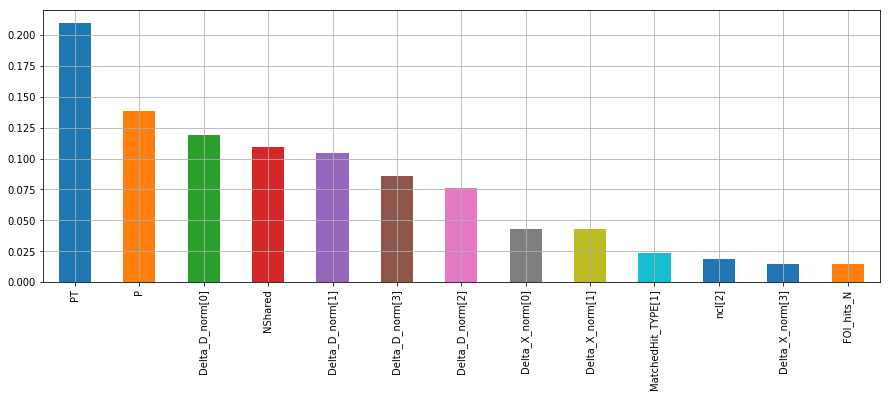

In [150]:
best_features = pd.DataFrame(models).set_index('name').loc['f13_s75_e30'].best_features
best_features.plot(kind='bar', grid=True, figsize=(15,5))

In [151]:
len(best_features[best_features>0.05*best_features.iloc[0]])

13

### Сводная информация

In [21]:
[(model['name'], model['score'], len(model['best_features'])) for model in models]

[('baseline', 0.5143225054344271, 65),
 ('baseline_pions', 0.3935499402228077, 65),
 ('baseline_protons', 0.6134756423538318, 65),
 ('DR', 0.6250819077160499, 69),
 ('DR_extra', 0.6431243354365355, 69),
 ('DR_extra_pions', 0.34092408316195943, 89),
 ('DR_extra_protons', 0.6805857548343868, 89),
 ('DR_selected', 0.6173539433586955, 31),
 ('DR_selected_pions', 0.33163326869032, 31),
 ('DR_selected_protons', 0.6725782871071051, 31),
 ('DXYR_extra', 0.6895572135142524, 97),
 ('DXYR_DDXY_extra', 0.6878244371167579, 109),
 ('DXYR_DDXY_extra_50', 0.6868673151651012, 50),
 ('DXYR_extra_50', 0.6851011117775935, 50),
 ('DXYR_DDXY_DIFF_extra', 0.6919758665233438, 165),
 ('DXYR_DDXY_DIFF_extra_65', 0.67496235796777, 65),
 ('systematic_1_45', 0.7179441741639653, 45),
 ('small_100', 0.7709064952303589, 45),
 ('small_10', 0.7166076011218043, 45),
 ('small_10', 0.7166076011218043, 45),
 ('small_10', 0.779596102477749, 45),
 ('track_2_10s_100f', 0.7119185510026159, 45),
 ('track_2_10s_100f', 0.71191855

In [14]:
[(model['name'], model['score'], len(model['best_features'])) for model in models[-33:len(models):3]]

[('data10_f13_s75_e100_REF', 0.7105070739692917, 13),
 ('data10_feature_selection_153_REF', 0.7091159731236308, 153),
 ('data10_feature_selection_100_REF', 0.7053004307187463, 100),
 ('data10_feature_selection_80_REF', 0.6946553917233225, 80),
 ('data10_feature_selection_60_REF', 0.703478040044913, 60),
 ('data10_feature_selection_50_REF', 0.7065657187954021, 50),
 ('data10_feature_selection_45_REF', 0.7093879361431973, 45),
 ('data10_feature_selection_SF45_REF', 0.7119185510026159, 45),
 ('best_model_60_50_PROTON', 0.8366400589112157, 60),
 ('best_model10_60_50_PROTON', 0.8081614170877118, 60),
 ('best_model_60_50_PION', 0.6725068044583445, 50)]

### Формирование ответа

In [12]:
model.fit(train.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values, train.label, sample_weight=train.weight)

[18:53:50] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [13]:
predictions = model.predict_proba(test.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]

In [14]:
pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv(
    "sample_submission.csv", index_label=utils.ID_COLUMN)

In [18]:
model_track_2 = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1).fit(
    train.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values, train.label, sample_weight=train.weight)

[19:26:52] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


In [19]:
model_track_2.save_model("track_2_baseline_simple_python/track_2_model.xgb")

### Общие определения

In [207]:
def get_score(model, params, X, y, scoring='roc_auc'):
    model.set_params(**params)
    if scoring == 'oob':
        model.fit(X, y)
        return model.oob_score_
    else:
        return model_selection.cross_val_score(model, X=X, y=y, scoring=scoring).mean()

def show_features(model, X, y, feature_names, **pd_params):
    model.fit(X=X, y=y)
    plt.ylabel('feature_importances')
    pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False).plot(kind='bar', grid=True, **pd_params)

def show_tree(model, X, y, feature_names, class_names):
    model.fit(X=X, y=y)
    dot_data = tree.export_graphviz(model, out_file=None, feature_names=feature_names, class_names=class_names, rounded=True, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_png('graph.png')
    return Image('graph.png')

def plot_scores(model, param1, param1_lst, param2, param2_lst, X, y, scoring='roc_auc'):
    plt.grid()
    plt.xlabel(param1)
    plt.ylabel(scoring)

    for param2_val in param2_lst:
        scores = [get_score(model, {param1: param1_val, param2: param2_val}, X, y, scoring) for param1_val in param1_lst]
        plt.plot(param1_lst, scores, label=f'{param2}={param2_val}')

    plt.legend();

def plot_scores1(model, param1, param1_lst, X, y, scoring='roc_auc', kind='plot'):
    plt.grid()
    plt.xlabel(param1)
    plt.ylabel(scoring)
    scores = [get_score(model, {param1: param1_val}, X, y, scoring) for param1_val in param1_lst]
    if kind=='plot':
        plt.plot(param1_lst, scores)
    elif kind=='bar':
        plt.ylim(np.round(0.9*min(scores), 2), np.round(1.01*max(scores), 2))
        plt.bar([str(param) for param in param1_lst], scores, color=plt.get_cmap('tab10').colors)
    
def heatmap_scores(model, param1, param1_lst, param2, param2_lst, X, y, **sns_params):
    scores_tab = pd.DataFrame(
        [[get_score(model, {param1: param1_val, param2: param2_val}, X, y) for param1_val in param1_lst] for param2_val in param2_lst],
        index=param2_lst, columns=param1_lst)
    scores_tab.index.name = param2
    scores_tab.columns.name = param1

    sns.heatmap(
        scores_tab, 
        cmap='Reds', linewidth=0.1, annot=True, **sns_params);

def plot_gs_results(cv_results):
    train_scores = cv_results['mean_train_score']
    test_scores = cv_results['mean_test_score']
    param_names = str(tuple(cv_results['params'][0].keys()))
    params = [str(tuple(item.values())) for item in cv_results['params']]
    scores_df = pd.DataFrame([train_scores, test_scores], index=['train', 'test'], columns=pd.Series(params, name=param_names)).T.sort_values('test', ascending=False)
    ylim_bottom = np.round(0.9*scores_df.min().min(), 2)
    ylim_top = np.round(1.01*scores_df.max().max(), 2)
    scores_df.plot(kind='bar', grid=True, figsize=(15,5), ylim=(ylim_bottom, ylim_top))
    
def plot_pr_roc(y_true, y_score):
    precision, recall, pr_thresholds = metrics.precision_recall_curve(y_true, y_score)
    fpr, tpr, roc_thresholds = metrics.roc_curve(y_true, y_score)
    accuracy = [metrics.accuracy_score(y_true, y_score>=threshold) for threshold in pr_thresholds]

    fig, axs = plt.subplots(2, 2, figsize=(15,6))
    plt.tight_layout(pad=2)
    axs = axs.ravel()

    plt.sca(axs[0])
    plt.grid(True)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.step(recall, precision)

    plt.sca(axs[2])
    plt.grid(True)
    plt.xlabel('thresholds')
    plt.ylabel('recall, precision, accuracy')
    plt.step(pr_thresholds, recall[:-1], label='recall', c='red')
    plt.step(pr_thresholds, precision[:-1], label='precision', c='green')
    plt.step(pr_thresholds, accuracy, label='accuracy', c='grey', linestyle='dashed')
    plt.legend();

    plt.sca(axs[1])
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.step(fpr, tpr, label='roc_curve')

    plt.sca(axs[3])
    plt.grid(True)
    plt.xlabel('thresholds')
    plt.ylabel('FPR, TPR, accuracy')
    plt.step(roc_thresholds[::-1][:-1], fpr[::-1][:-1], label='FPR', c='red')
    plt.step(roc_thresholds[::-1][:-1], tpr[::-1][:-1], label='TPR', c='green')

    plt.step(pr_thresholds, accuracy, label='accuracy', c='grey', linestyle='dashed')
    plt.legend();
    
def get_scores(y_true, y_pred):
    ((TN, FP),(FN, TP)) = metrics.confusion_matrix(y_true, y_pred)
    return {
        'FPR': FP/(TN+FP),
        'TPR': TP/(TP+FN),
        'Recall': TP/(TP+FN),
        'Precision': TP/(TP+FP),
        'Accuracy': (TP+TN)/(TP+TN+FP+FN)
    }

def confint(arr, alpha=0.05):
    return (np.percentile(arr, 100*alpha/2), np.percentile(arr, 100*(1-alpha/2)))